<a href="https://colab.research.google.com/github/dongsikchoi/ML_Time-Series_EDA/blob/master/BG_Prediction_Univariate_Filter_X_01_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
# Colab
#from google.colab import auth
#auth.authenticate_user()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [5]:
#df=pd.read_excel("BG_Dataset/BG_Sample55.xlsx")

In [344]:
# Colab
df = pd.read_excel("/content/drive/MyDrive/BG_Dataset/BG_sample19.xlsx")
#df = pd.read_csv("/content/drive/MyDrive/BG_Dataset/BG_Sample46.csv")


In [345]:
df.shape

(934, 14)

In [8]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    3   
2    3                        NaN   생년월일       NaN  1983-01-24 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고   긴급하게 낮음                  NaN   
10  11        2020-03-13T11:05:03     교정       NaN                  NaN   
11  12        2020-03-13T11:14:06     교정       NaN                  NaN   
12  13        2020-03-13T11:15:55    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID 포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN           NaN       NaN          NaN   
1                    NaN      NaN           NaN       NaN          NaN   
2                    NaN      NaN           NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android           NaN       NaN          NaN   
4                    NaN  Android           NaN       NaN          NaN   
5                    NaN  Android           250       NaN          NaN   
6                    NaN  Android            70       NaN          NaN   
7                    NaN  Android           NaN       NaN          NaN   
8                    NaN  Android           NaN       NaN          NaN   
9                    NaN  Android            55       NaN          NaN   
10                   NaN  Android           216       NaN          NaN   
11                   NaN  Android           244       NaN          NaN   
12                   NaN  Android           227       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   42E570  
11          NaN                  NaN               NaN   42E570  
12          NaN                  NaN         6134328.0   42E570

In [9]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [10]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event',
             '인슐린 값(u)':'Insulin','탄수화물 값 (그램)':'Meal'},axis='columns')

In [11]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
경고         6
교정         4
이름         1
생년월일       1
장치         1
성          1
Name: Event, dtype: int64

In [12]:
df['Glucose'].value_counts()

높음     169
199     27
187     20
185     19
197     18
      ... 
362      1
366      1
367      1
171      1
55       1
Name: Glucose, Length: 242, dtype: int64

In [13]:
df.tail()

Timestamp Event Glucose  Insulin  Meal
1469  2020-03-18T09:20:43   EGV      높음      NaN   NaN
1470  2020-03-18T09:25:44   EGV      높음      NaN   NaN
1471  2020-03-18T09:30:43   EGV      높음      NaN   NaN
1472  2020-03-18T09:35:44   EGV      높음      NaN   NaN
1473  2020-03-18T09:40:44   EGV      높음      NaN   NaN

In [14]:
# 인슐린 투여횟수
df['Insulin'].value_counts()

0.0    21
Name: Insulin, dtype: int64

In [15]:
# 식사 횟수
df['Meal'].value_counts()

0.0    17
Name: Meal, dtype: int64

In [16]:
df.head(15)

Timestamp Event Glucose  Insulin  Meal
0                   NaN    이름     NaN      NaN   NaN
1                   NaN     성     NaN      NaN   NaN
2                   NaN  생년월일     NaN      NaN   NaN
3                   NaN    장치     NaN      NaN   NaN
4                   NaN    경고     NaN      NaN   NaN
5                   NaN    경고     250      NaN   NaN
6                   NaN    경고      70      NaN   NaN
7                   NaN    경고     NaN      NaN   NaN
8                   NaN    경고     NaN      NaN   NaN
9                   NaN    경고      55      NaN   NaN
10  2020-03-13T11:05:03    교정     216      NaN   NaN
11  2020-03-13T11:14:06    교정     244      NaN   NaN
12  2020-03-13T11:15:55   EGV     227      NaN   NaN
13  2020-03-13T11:20:50   EGV     227      NaN   NaN
14  2020-03-13T11:25:49   EGV     224      NaN   NaN

In [17]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [18]:
df.head(20)

Timestamp Event Glucose  Insulin  Meal
10  2020-03-13T11:05:03    교정     216      NaN   NaN
11  2020-03-13T11:14:06    교정     244      NaN   NaN
12  2020-03-13T11:15:55   EGV     227      NaN   NaN
13  2020-03-13T11:20:50   EGV     227      NaN   NaN
14  2020-03-13T11:25:49   EGV     224      NaN   NaN
15  2020-03-13T11:30:49   EGV     223      NaN   NaN
16  2020-03-13T11:35:49   EGV     222      NaN   NaN
17  2020-03-13T11:40:50   EGV     222      NaN   NaN
18  2020-03-13T11:45:51   EGV     218      NaN   NaN
19  2020-03-13T11:50:49   EGV     218      NaN   NaN
20  2020-03-13T11:55:50   EGV     218      NaN   NaN
21  2020-03-13T12:00:51   EGV     223      NaN   NaN
22  2020-03-13T12:05:50   EGV     217      NaN   NaN
23  2020-03-13T12:10:50   EGV     201      NaN   NaN
24  2020-03-13T12:11:14   인슐린     NaN      0.0   NaN
25  2020-03-13T12:11:34  탄수화물     NaN      NaN   0.0
26  2020-03-13T12:15:50   EGV     197      NaN   NaN
27  2020-03-13T12:20:50   EGV     196      NaN   NaN
28  2020-03-13T12:25:50   EGV     191      NaN   NaN
29  2020-03-13T12:30:49   EGV     195      NaN   NaN

In [19]:
df.shape

(1464, 5)

In [20]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [21]:
df.head(15)

Timestamp Event Glucose  Insulin  Meal
0   2020-03-13T11:05:03    교정     216      NaN   NaN
1   2020-03-13T11:14:06    교정     244      NaN   NaN
2   2020-03-13T11:15:55   EGV     227      NaN   NaN
3   2020-03-13T11:20:50   EGV     227      NaN   NaN
4   2020-03-13T11:25:49   EGV     224      NaN   NaN
5   2020-03-13T11:30:49   EGV     223      NaN   NaN
6   2020-03-13T11:35:49   EGV     222      NaN   NaN
7   2020-03-13T11:40:50   EGV     222      NaN   NaN
8   2020-03-13T11:45:51   EGV     218      NaN   NaN
9   2020-03-13T11:50:49   EGV     218      NaN   NaN
10  2020-03-13T11:55:50   EGV     218      NaN   NaN
11  2020-03-13T12:00:51   EGV     223      NaN   NaN
12  2020-03-13T12:05:50   EGV     217      NaN   NaN
13  2020-03-13T12:10:50   EGV     201      NaN   NaN
14  2020-03-13T12:11:14   인슐린     NaN      0.0   NaN

In [22]:
df.shape

(1464, 5)

In [23]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]
insulin_list=[]
meal_list=[]

In [24]:
def isNaN(num):
    return num==num

In [25]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [26]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [27]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [28]:
# 인슐린 카운트 
#def insul_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            insulin_list.append(i)
#    print('인슐린 : ',count)

In [29]:
# 인슐린 카운트 
def insul_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            insulin_list.append(i)
    print('인슐린 : ',count)

In [30]:
# 식사 횟수 카운트 
#def meal_count(df,col):
#    count=0
#    for i, row in df.iterrows():
#         val = row[col]
#         if val==0:
#            count=count+1
#            meal_list.append(i)
#    print('식사 횟수 : ',count)

In [31]:
# 식사 횟수 카운트 
def meal_count(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if isNaN(val)==True:
            count=count+1
            meal_list.append(i)
    print('식사 횟수 : ',count)

In [32]:
glucose_count_high(df,'Glucose')

높음 :  169


In [33]:
print('높음 개수 :',len(high_list))

높음 개수 : 169


In [34]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [35]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [36]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [37]:
low_list

[]

In [38]:
calibration_count_low(df,'Event')

교정 :  4


In [39]:
calib_list

[0, 1, 139, 414]

In [40]:
insul_count(df,'Insulin')

인슐린 :  21


In [41]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429]

In [42]:
meal_count(df,'Meal')

식사 횟수 :  17


In [43]:
meal_list

[15,
 78,
 249,
 313,
 373,
 541,
 543,
 605,
 670,
 837,
 903,
 967,
 968,
 1133,
 1198,
 1260,
 1431]

In [44]:
df['Insulin'].value_counts()

0.0    21
Name: Insulin, dtype: int64

In [45]:
df['Meal'].value_counts()

0.0    17
Name: Meal, dtype: int64

In [46]:
isNaN(df['Glucose'][14])

False

In [47]:
import math
for i in insulin_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Insulin'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Insulin'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Insulin'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Insulin'][i+4]=0
        continue

In [48]:
for i in meal_list:
    
    if isNaN(df['Glucose'][i+1]):
        df['Meal'][i+1]=0
        continue
    if isNaN(df['Glucose'][i+2]):
        df['Meal'][i+2]=0
        continue
    if isNaN(df['Glucose'][i+3]):
        df['Meal'][i+3]=0
        continue
    if isNaN(df['Glucose'][i+4]):
        df['Meal'][i+4]=0
        continue

In [49]:
import math
math.isnan(df['Glucose'][14])

True

In [50]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429]

In [51]:
SetList1 = set(insulin_list)
SetList2 = set(meal_list)

C = list((SetList2.difference(SetList1)))

insulin_list.extend(C)

In [52]:
insulin_list

[14,
 63,
 243,
 308,
 372,
 428,
 540,
 542,
 604,
 669,
 720,
 838,
 901,
 966,
 969,
 1134,
 1199,
 1216,
 1261,
 1317,
 1429,
 541,
 837,
 249,
 967,
 903,
 968,
 1260,
 1133,
 78,
 15,
 1198,
 373,
 1431,
 313,
 605,
 670,
 543]

In [53]:
df=df.drop(insulin_list)

In [54]:
df[10:20]

Timestamp Event Glucose  Insulin  Meal
10  2020-03-13T11:55:50   EGV     218      NaN   NaN
11  2020-03-13T12:00:51   EGV     223      NaN   NaN
12  2020-03-13T12:05:50   EGV     217      NaN   NaN
13  2020-03-13T12:10:50   EGV     201      NaN   NaN
16  2020-03-13T12:15:50   EGV     197      0.0   0.0
17  2020-03-13T12:20:50   EGV     196      NaN   NaN
18  2020-03-13T12:25:50   EGV     191      NaN   NaN
19  2020-03-13T12:30:49   EGV     195      NaN   NaN
20  2020-03-13T12:35:50   EGV     199      NaN   NaN
21  2020-03-13T12:40:51   EGV     223      NaN   NaN

In [55]:
df['Glucose'].unique()

array([216, 244, 227, 224, 223, 222, 218, 217, 201, 197, 196, 191, 195,
       199, 237, 257, 269, 277, 274, 275, 280, 286, 279, 281, 276, 265,
       266, 260, 262, 254, 250, 243, 235, 238, 239, 236, 229, 219, 210,
       207, 204, 203, 205, 193, 189, 178, 175, 185, 198, 183, 182, 200,
       190, 180, 176, 162, 157, 145, 150, 147, 153, 158, 169, 174, 179,
       247, 253, 246, 248, 289, 287, 245, 261, 256, 249, 263, 259, 226,
       206, 184, 186, 187, 202, 181, 172, 167, 165, 163, 303, 271, 264,
       242, 234, 228, 221, 220, 215, 213, 214, 212, 188, 173, 168, 192,
       209, 240, 231, 232, 309, 327, 353, 371, 375, '높음', 397, 396, 398,
       383, 364, 345, 348, 347, 336, 332, 331, 324, 315, 311, 306, 296,
       293, 291, 273, 251, 252, 349, 387, 386, 384, 382, 379, 393, 394,
       390, 374, 367, 360, 354, 351, 355, 339, 330, 368, 370, 377, 399,
       365, 359, 343, 346, 352, 350, 328, 337, 338, 333, 283, 268, 267,
       255, 241, 230, 211, 208, 194, 312, 356, 385, 378, 376, 3

In [56]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1407
Meal         1411
dtype: int64

In [57]:
df['Event'].value_counts()

EGV    1422
교정        4
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [58]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [59]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400
        elif val > 400:
            df.loc[i,col]=400

In [60]:
fix_glucose_low(df,'Glucose')

In [61]:
fix_glucose(df,'Glucose')

In [62]:
df['Glucose'].value_counts()

400    169
199     27
187     20
185     19
197     18
      ... 
171      1
169      1
389      1
366      1
145      1
Name: Glucose, Length: 240, dtype: int64

In [63]:
df.isnull().sum()

Timestamp       0
Event           0
Glucose         0
Insulin      1407
Meal         1411
dtype: int64

In [64]:
df['Event'].unique()

array(['교정', 'EGV'], dtype=object)

In [65]:
## 이벤트에 '운동' 있어서 혈당값 비어있음 
# 모델 안돌아감 
df=df.dropna(subset=['Glucose'])

In [66]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [67]:
new_insul_list =[]
new_meal_list =[]
new_insul_and_meal_list=[]

for i in range(len(df)):
    if (df['Insulin'][i] ==0 and df['Meal'][i]==0):
        new_insul_and_meal_list.append(i)
    if (df['Insulin'][i]==0 and df['Meal'][i]!=0):
        new_insul_list.append(i)
    if (df['Insulin'][i]!=0 and df['Meal'][i]==0):
        new_meal_list.append(i)

In [68]:
new_meal_list

[75, 244, 306, 880, 1394]

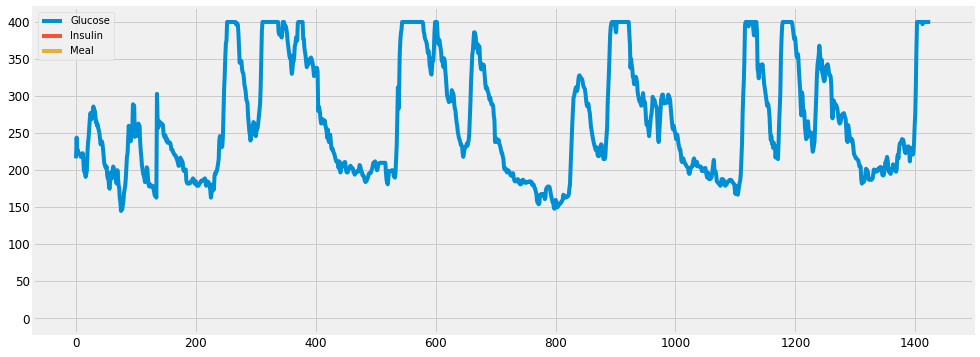

In [69]:
df.plot(figsize=(15,6))
plt.show()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


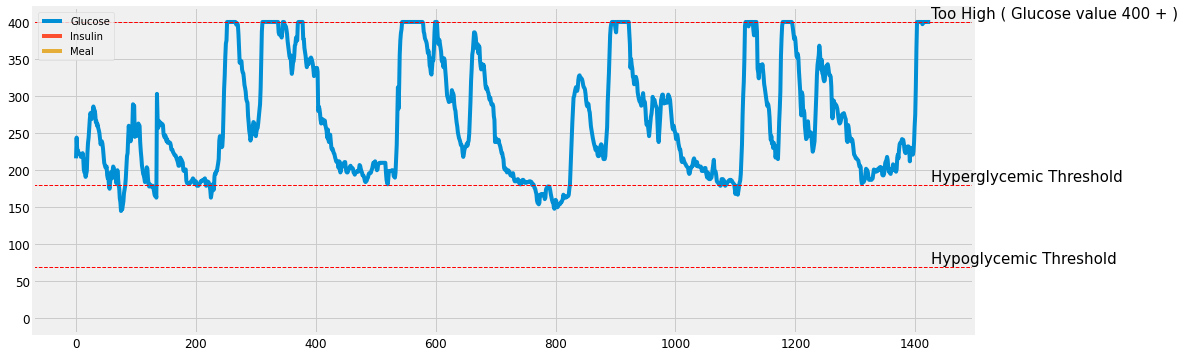

In [70]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [71]:
#df.drop(0,inplace=True)

In [72]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [73]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
#insul=list()
#import math
#def interpolate_glucose(df,col):
#    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
#        if math.isnan(val):
#            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
                
#            if df['Glucose'][i-2] < df['Glucose'][i-1]:
#                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
#                df.loc[i,col]= df['Glucose'][i-1] - c
#                insul.append(i)
#                print(insul)
        
           

In [74]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [75]:
#interpolate_glucose(df,'Glucose')

In [76]:
#meal

In [77]:
#insul

In [78]:
df['Glucose'].isnull().sum()

0

In [79]:
insul_glucose_value=list()
for i in new_insul_list:
    insul_glucose_value.append(df['Glucose'][i])

In [80]:
meal_glucose_value=list()
for i in new_meal_list:
    meal_glucose_value.append(df['Glucose'][i])

In [81]:
insul_and_meal_glucose_value = list()
for i in new_insul_and_meal_list:
    insul_and_meal_glucose_value.append(df['Glucose'][i])

In [82]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


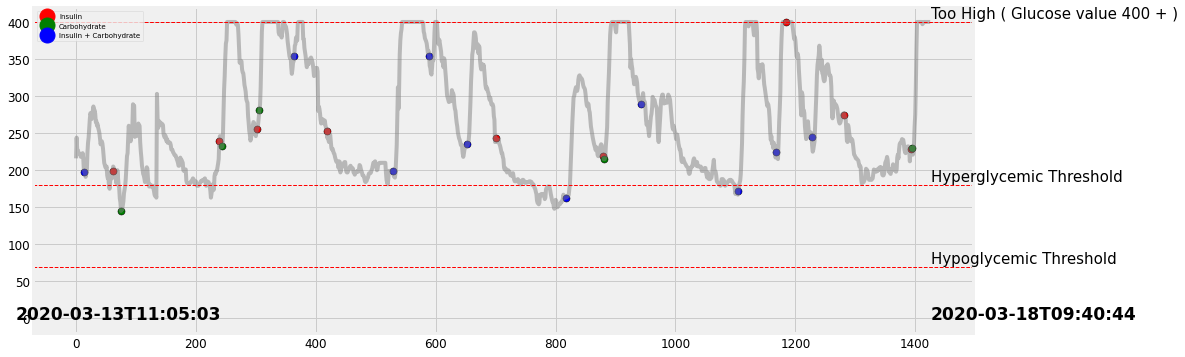

In [83]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

df.plot(figsize=(15,6),color='gray',alpha=0.5)
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)

plt.scatter(new_insul_list,insul_glucose_value,edgecolor='black',s=50,label='Insulin',marker='o',c='red')
plt.scatter(new_meal_list,meal_glucose_value,edgecolor='black',s=50,label='Carbohydrate',marker='o',c='green')
plt.scatter(new_insul_and_meal_list,insul_and_meal_glucose_value,edgecolor='black',s=50,label='Insulin + Carbohydrate',marker='o',c='blue')

red_patch = mpatches.Patch(color='red',label='Insulin')

red_line = mlines.Line2D([],[],color='red',marker='o',markersize=15,label='Insulin')
green_line = mlines.Line2D([],[],color='green',marker='o',markersize=15,label='Carbohydrate')
blue_line = mlines.Line2D([],[],color='blue',marker='o',markersize=15,label='Insulin + Carbohydrate')
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.legend(['Insulin','Carbohydrate','Insulin + Carbohydrate'],loc='best',fontsize='x-small',handles=[red_line,green_line,blue_line])
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',

#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [84]:
for i in range(len(df)):
    if isNaN(df['Insulin'][i]):
        df['Insulin'][i]=1
    else:
        df['Insulin'][i]=0
        
     

In [85]:
for i in range(len(df)):
    if isNaN(df['Meal'][i]):
        df['Meal'][i]=1
    else:
        df['Meal'][i]=0
        

In [86]:
df[1900:1950]

Empty DataFrame
Columns: [Timestamp, Event, Glucose, Insulin, Meal]
Index: []

In [87]:
def fix_glucose_value(df,col):
    for i, row in df.iterrows():
        val = row[col]
        
        df.loc[i,col] = math.floor(val)

In [88]:
fix_glucose_value(df,'Glucose')

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [89]:
import numpy as np
import tensorflow as tf
import random as rn

In [90]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [91]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [92]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [93]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [94]:
leaky_relu = tf.nn.leaky_relu

## 15분

In [95]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [96]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

In [97]:
len(raw_seq) * 0.7

998.1999999999999

In [98]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [99]:
# SG필터 적용하는 부분 
# x_train_uni_origin 이런 식이었음 
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=2 # 이거 -1이면 naive method 
#x_train_uni,y_train_uni = uni_data(,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)

In [100]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [101]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [102]:
y_val_uni.shape

(420,)

In [103]:
y_train_uni.shape

(992,)

In [104]:
#y_train_uni_origin[:10]

In [105]:
#y_train_uni.shape
df[:15]

Timestamp Event Glucose  Insulin  Meal
0   2020-03-13T11:05:03    교정     216      0.0   0.0
1   2020-03-13T11:14:06    교정     244      0.0   0.0
2   2020-03-13T11:15:55   EGV     227      0.0   0.0
3   2020-03-13T11:20:50   EGV     227      0.0   0.0
4   2020-03-13T11:25:49   EGV     224      0.0   0.0
5   2020-03-13T11:30:49   EGV     223      0.0   0.0
6   2020-03-13T11:35:49   EGV     222      0.0   0.0
7   2020-03-13T11:40:50   EGV     222      0.0   0.0
8   2020-03-13T11:45:51   EGV     218      0.0   0.0
9   2020-03-13T11:50:49   EGV     218      0.0   0.0
10  2020-03-13T11:55:50   EGV     218      0.0   0.0
11  2020-03-13T12:00:51   EGV     223      0.0   0.0
12  2020-03-13T12:05:50   EGV     217      0.0   0.0
13  2020-03-13T12:10:50   EGV     201      0.0   0.0
14  2020-03-13T12:15:50   EGV     197      1.0   1.0

In [106]:
x_train_uni[5:10]

array([[[223],
        [222],
        [222],
        [218],
        [218],
        [218]],

       [[222],
        [222],
        [218],
        [218],
        [218],
        [223]],

       [[222],
        [218],
        [218],
        [218],
        [223],
        [217]],

       [[218],
        [218],
        [218],
        [223],
        [217],
        [201]],

       [[218],
        [218],
        [223],
        [217],
        [201],
        [197]]])

In [107]:
y_train_uni[5:10]

array([201, 197, 196, 191, 195])

In [108]:
#df['Glucose'].head(10)

In [109]:
x_train_uni.shape[-2:]

(6, 1)

### RNN - 15분

In [110]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [111]:
from keras.layers import SimpleRNN

In [112]:
#n_steps = 3
#delay=3
#n_features=1

In [113]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [114]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False)) #recurrent_dropout=0.2
model.add(Dense(1))

In [115]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_rnn_15_predict_result = model.predict(x_val_uni,verbose=0)

In [116]:
# 예측값 상한선 = 400 
for i in range(len(val_rnn_15_predict_result)):
    if val_rnn_15_predict_result[i] >= 400: 
        val_rnn_15_predict_result[i]=400
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,val_rnn_15_predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,val_rnn_15_predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  19.58133092538072


#### Validation

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


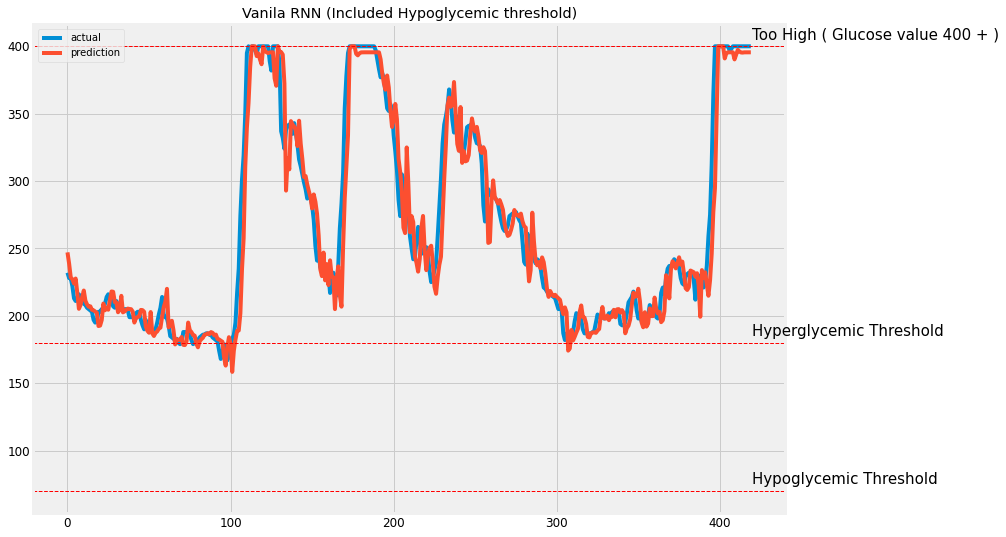

In [117]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [118]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

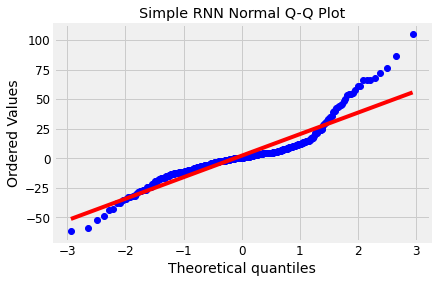

In [119]:
residuals = [y_val_uni_origin[i]-val_rnn_15_predict_result[i] for i in range(len(val_rnn_15_predict_result))]
residuals = y_val_uni_origin - val_rnn_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

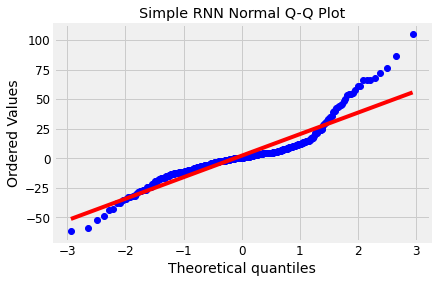

In [120]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [121]:
residuals=DataFrame(residuals)

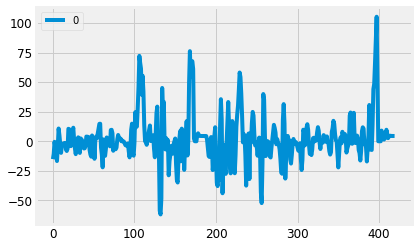

In [122]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1df0b36c90>]],
      dtype=object)

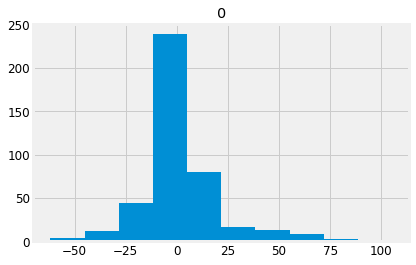

In [123]:

residuals.hist()

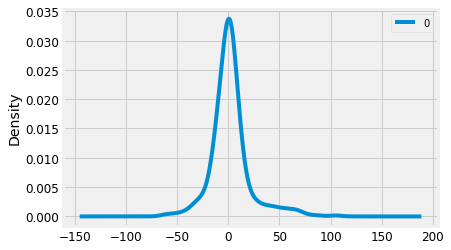

In [124]:
residuals.plot(kind='kde')

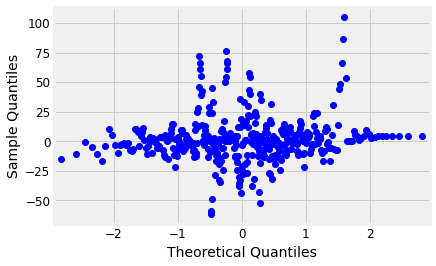

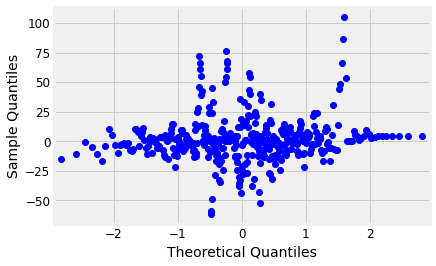

In [125]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [126]:
# 트레이닝셋 rmse 구하는 부분 
train_rnn_15_predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(train_rnn_15_predict_result)):
    if train_rnn_15_predict_result[i] >= 400: 
        train_rnn_15_predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,train_rnn_15_predict_result))
train_rnn_15=RMSE(y_train_uni_origin,train_rnn_15_predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  17.406503521521707


#### Train

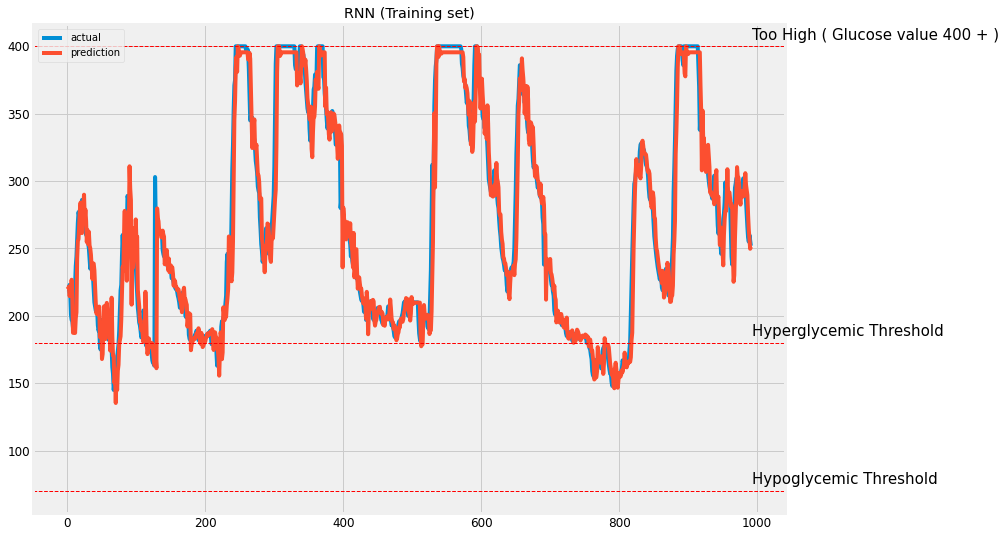

In [127]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

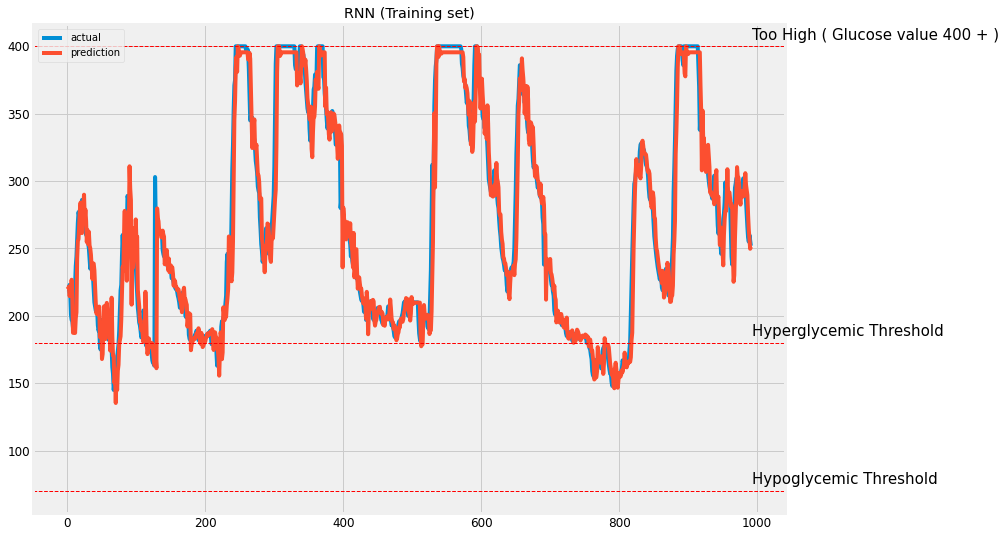

In [128]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_rnn_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_rnn_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_rnn_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [129]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [130]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:])) #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


In [131]:
model.compile(optimizer='adam',loss='mse')
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()
val_lstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [132]:
# 예측값 상한선 = 400 
for i in range(len(val_lstm_15_predict_result)):
    if val_lstm_15_predict_result[i] >= 400: 
        val_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,val_lstm_15_predict_result))
val_lstm_15=RMSE(y_val_uni_origin,val_lstm_15_predict_result)

 LSTM - RMSE (15min) :  20.463035125506895


In [133]:
TRAIN_SPLIT

998

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

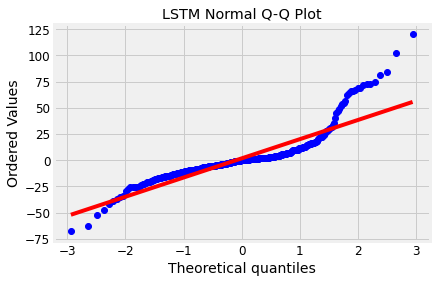

In [134]:
residuals = [y_val_uni_origin[i]-val_lstm_15_predict_result[i] for i in range(len(val_lstm_15_predict_result))]
residuals = y_val_uni_origin - val_lstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

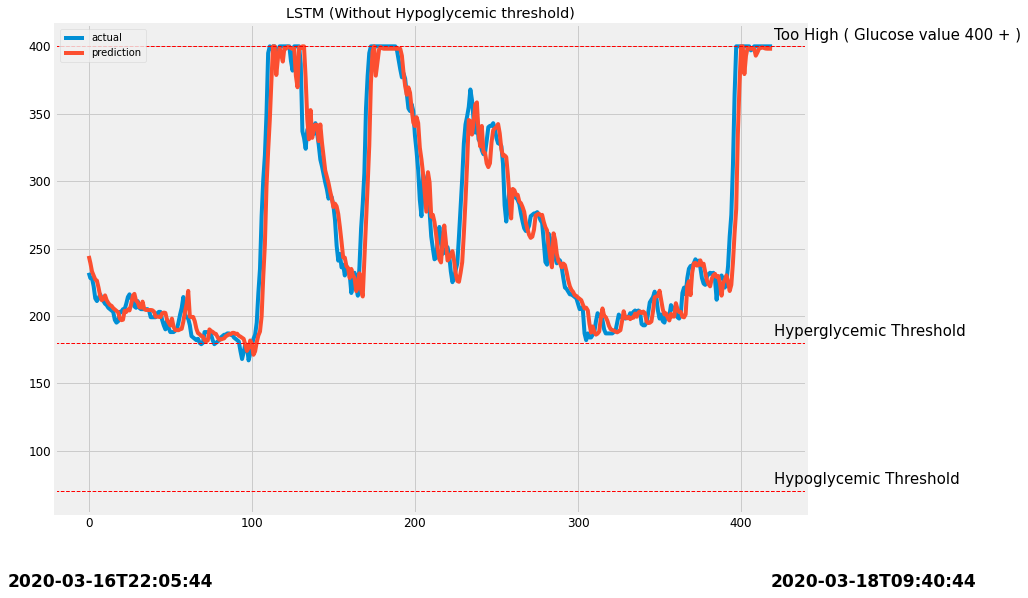

In [135]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [136]:
# 트레이닝셋 RMSE 계산 
train_lstm_15_predict_result = model.predict(x_train_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(train_lstm_15_predict_result)):
    if train_lstm_15_predict_result[i] >= 400: 
        train_lstm_15_predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,train_lstm_15_predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,train_lstm_15_predict_result)

 LSTM - RMSE (15min) Training set :  18.546729183882924


#### Train

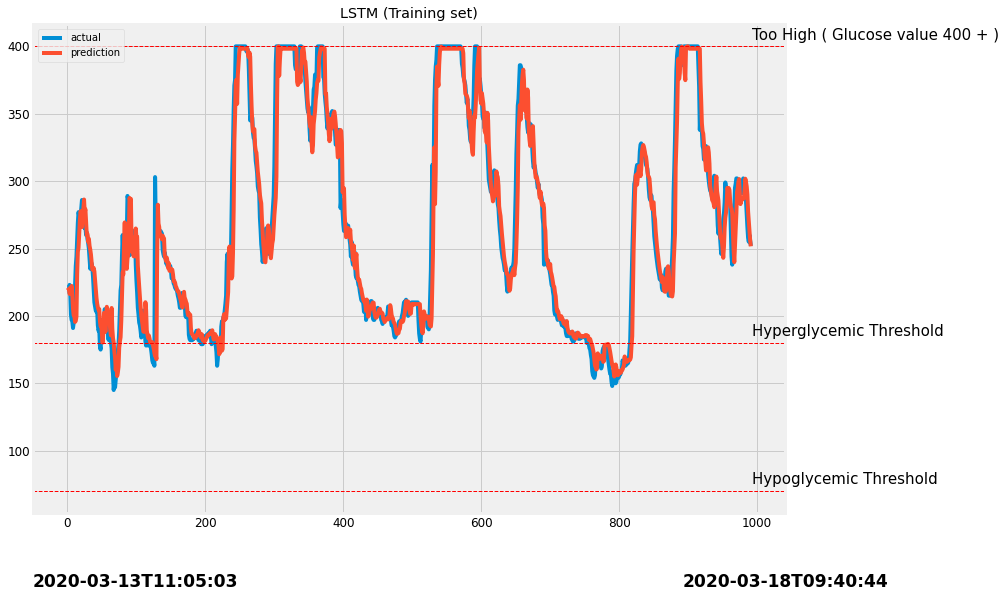

In [137]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(train_lstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(train_lstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(train_lstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(train_lstm_15_predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [138]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [139]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [140]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [141]:
K.clear_session()

In [142]:
val_slstm_15_predict_result = model.predict(x_val_uni,verbose=0)


In [143]:
for i in range(len(val_slstm_15_predict_result)):
    if val_slstm_15_predict_result[i] >= 400: 
        val_slstm_15_predict_result[i]=400

In [144]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,val_slstm_15_predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,val_slstm_15_predict_result)

 Stacked LSTM - RMSE(15min) :  17.530512516320677


#### Validation

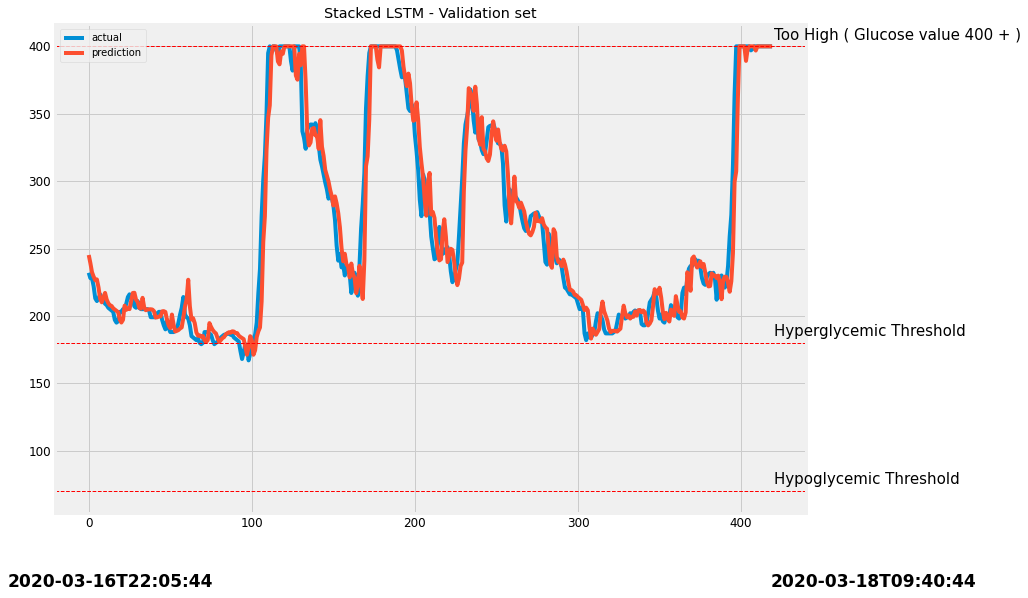

In [145]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_slstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_slstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(val_slstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_slstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

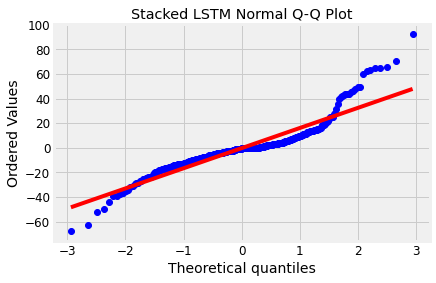

In [146]:
residuals = [y_val_uni[i]-val_slstm_15_predict_result[i] for i in range(len(val_slstm_15_predict_result))]
residuals = y_val_uni - val_slstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [147]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  16.84928430315149


#### Train

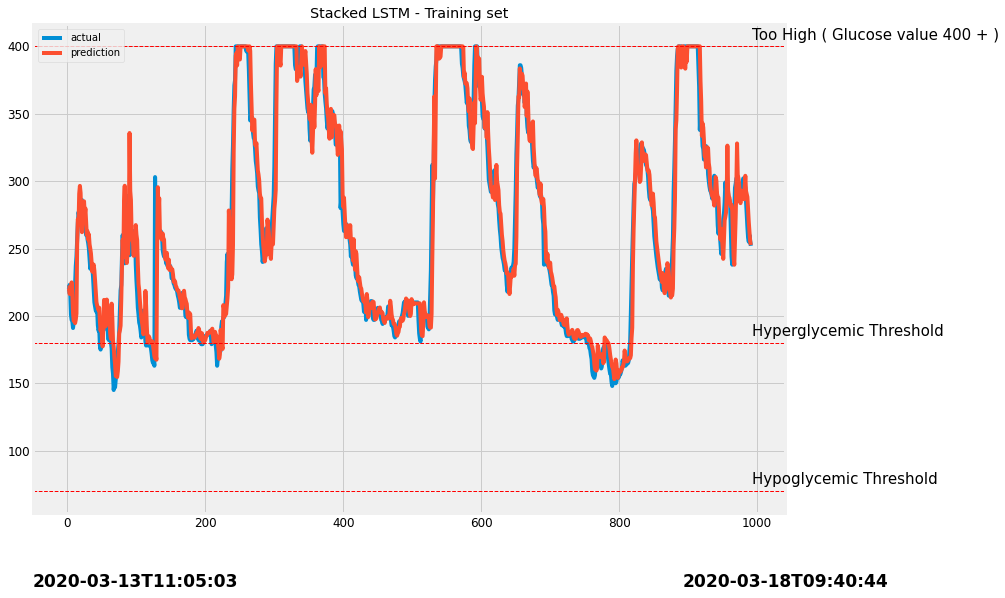

In [148]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [149]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [150]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [151]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [152]:
K.clear_session()

In [153]:
val_bilstm_15_predict_result = model.predict(x_val_uni,verbose=0)

In [154]:
for i in range(len(val_bilstm_15_predict_result)):
    if val_bilstm_15_predict_result[i] >= 400: 
        val_bilstm_15_predict_result[i]=400

In [155]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,val_bilstm_15_predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,val_bilstm_15_predict_result)

Bidirectional LSTM - RMSE :  18.663838364894076


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

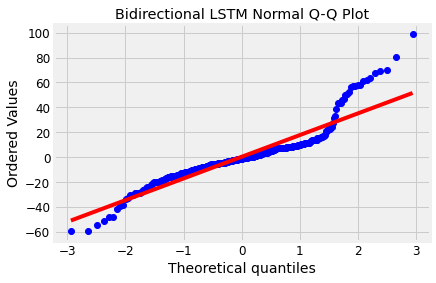

In [156]:
residuals = [y_val_uni[i]-val_bilstm_15_predict_result[i] for i in range(len(val_bilstm_15_predict_result))]
residuals = y_val_uni - val_bilstm_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

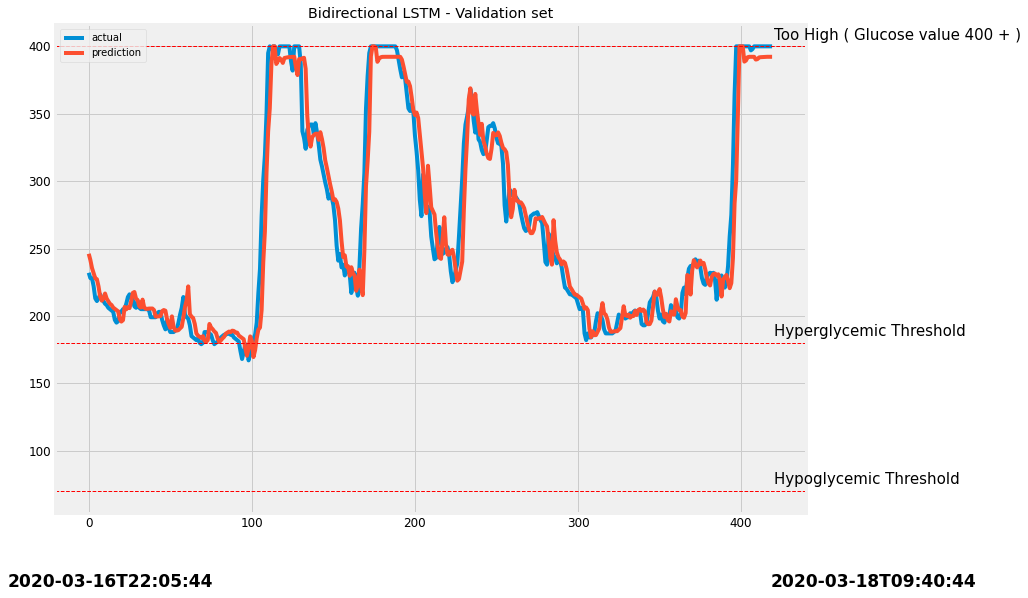

In [157]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_bilstm_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_bilstm_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_bilstm_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_bilstm_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [158]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  17.615753279338676


#### Train

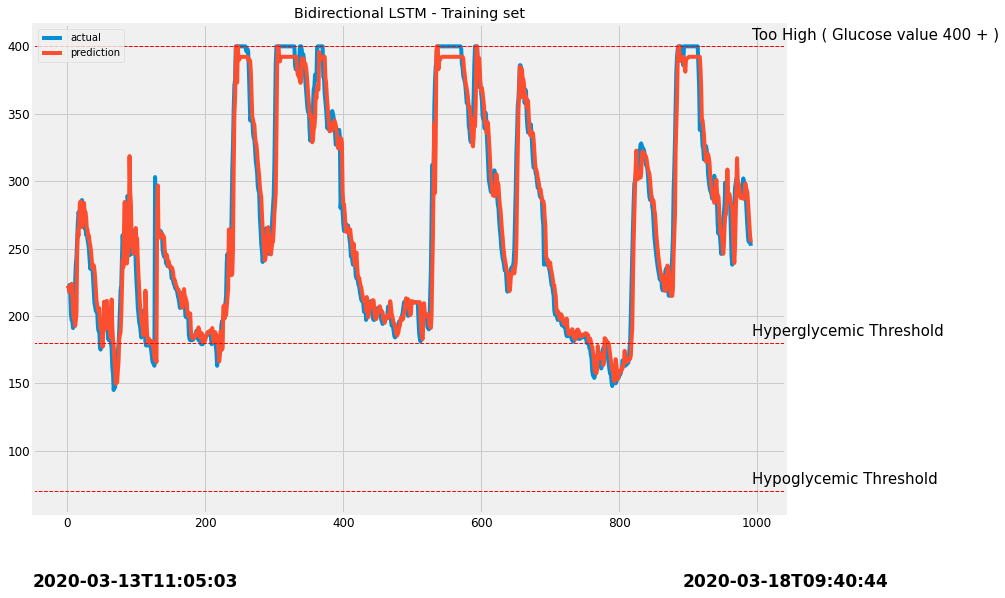

In [159]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [160]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [161]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [163]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [164]:
K.clear_session()

In [165]:
val_gru_15_predict_result = model.predict(x_val_uni,verbose=0)

In [166]:
for i in range(len(val_gru_15_predict_result)):
    if val_gru_15_predict_result[i] >= 400: 
        val_gru_15_predict_result[i]=400

In [167]:
#predict_result

In [168]:
#predict_result

In [169]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,val_gru_15_predict_result))
val_gru_15 = RMSE(y_val_uni_origin,val_gru_15_predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  18.98565771905785


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

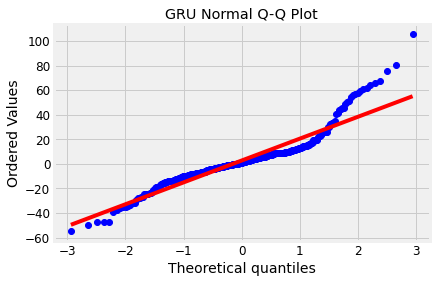

In [170]:
residuals = [y_val_uni[i]-val_gru_15_predict_result[i] for i in range(len(val_gru_15_predict_result))]
residuals = y_val_uni - val_gru_15_predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

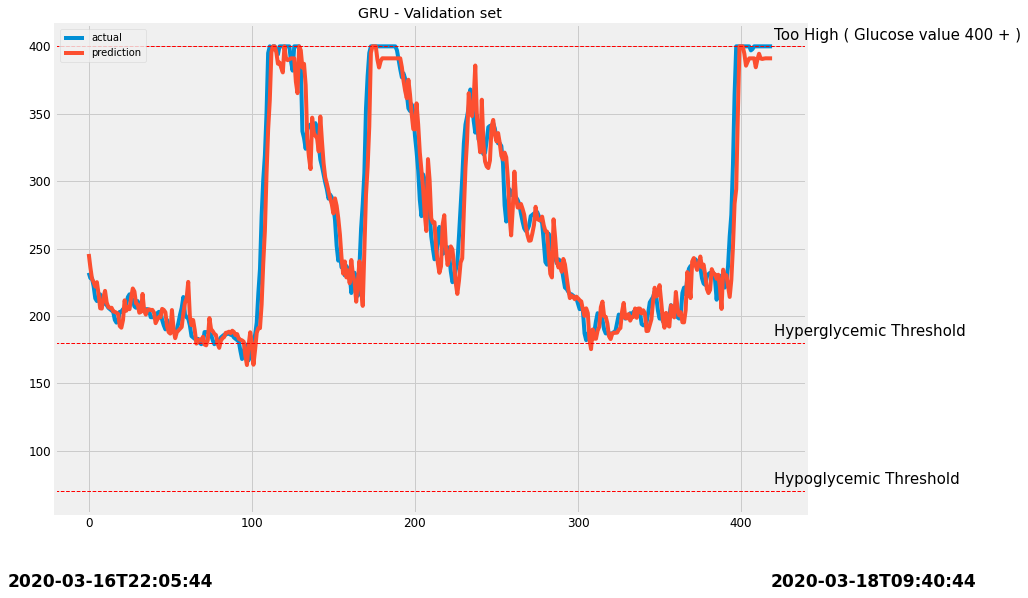

In [171]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(val_gru_15_predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(val_gru_15_predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(val_gru_15_predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(val_gru_15_predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [172]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  17.138179702712307


#### Train

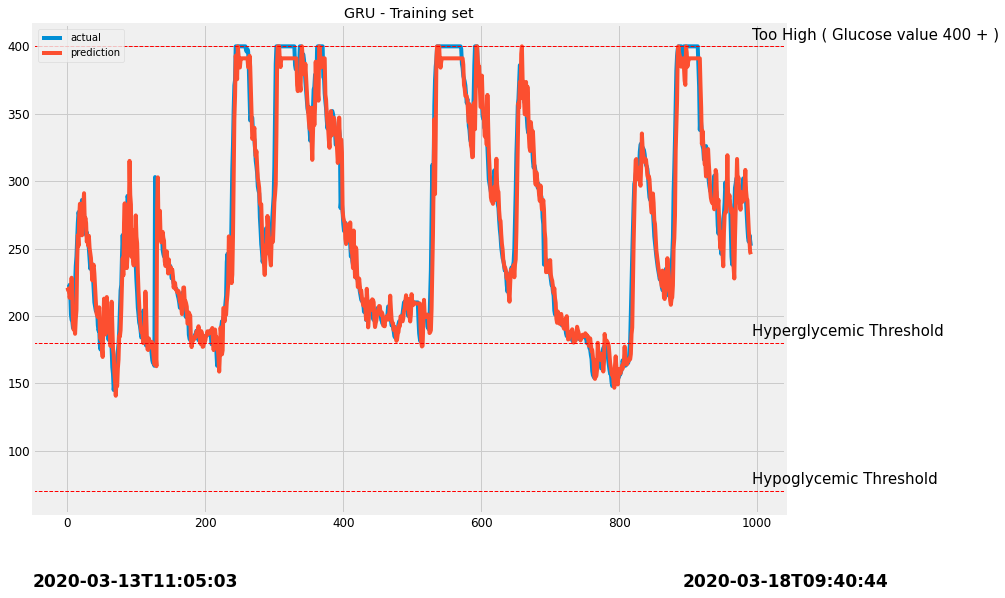

In [173]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [174]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [175]:
#residuals.plot(kind='kde')

In [176]:
#residuals.plot()

In [177]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

### Genetic Algorithm - 15Min

In [178]:
pip install geneticalgorithm2

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-cp37-none-any.whl size=15079 sha256=84218b410788ebd4fea0ba47b98fd76d448000bd961401e21fb59ace0b971112
  Stored in directory: /root/.cache/pip/wheels/46/7c/4f/24f1d2d5bbff92219debe7ea19af84f76ddeb90dd4ec544f26
Successfully built func-timeout


In [179]:
from geneticalgorithm2 import geneticalgorithm2 as ga # for creating and running optimization model

from geneticalgorithm2 import Crossover, Mutations, Selection # classes for specific mutation and crossover behavior

from geneticalgorithm2 import Population_initializer # for creating better start population

from geneticalgorithm2 import np_lru_cache # for cache function (if u want)

from geneticalgorithm2 import plot_pop_scores # for plotting population scores, if u want

from geneticalgorithm2 import Callbacks # simple callbacks

from geneticalgorithm2 import Actions, ActionConditions, MiddleCallbacks # middle callbacks

In [180]:
val_rnn_15 = round(val_rnn_15,2)
val_lstm_15 = round(val_lstm_15,2)
val_stacklstm_15 = round(val_stacklstm_15,2)
val_bilstm_15 = round(val_bilstm_15,2)
val_gru_15 = round(val_gru_15,2)


In [181]:
#val_rnn_15_predict_result[:5]

In [182]:
#ex = val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2

In [183]:
#ex = val_rnn_15_predict_result * 0.3 + val_lstm_15_predict_result * 0.1 + val_slstm_15_predict_result * 0.14 + val_bilstm_15_predict_result * 0.11 + val_gru_15_predict_result * 0.35

In [184]:
# Baseline
#test_result = RMSE(y_val_uni_origin,ex)
#test_result

In [185]:
#test_result = 200 - RMSE(y_val_uni_origin,ex)
#test_result = 200 - RMSE(val_rnn_15_predict_result * 0.2 + val_lstm_15_predict_result * 0.2 + val_slstm_15_predict_result * 0.2 + val_bilstm_15_predict_result * 0.2 + val_gru_15_predict_result * 0.2,ex)


In [186]:
val_rnn_15_predict_result = np.asarray(val_rnn_15_predict_result)
val_lstm_15_predict_result = np.asarray(val_lstm_15_predict_result)
val_slstm_15_predict_result = np.asarray(val_slstm_15_predict_result)
val_bilstm_15_predict_result = np.asarray(val_bilstm_15_predict_result)
val_gru_15_predict_result = np.asarray(val_gru_15_predict_result)

In [187]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 30 - np.sqrt(mean_squared_error(val_rnn_15_predict_result * X[0] + val_lstm_15_predict_result * X[1] +val_slstm_15_predict_result * X[2] + 
                                val_bilstm_15_predict_result * X[3] + val_gru_15_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [188]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [189]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [190]:
model1 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.10965169]

 ** C ** 

11.971682055879917

 ** B ** 

[0.05344362 0.05074547 0.49862704 0.28752176 0.109651

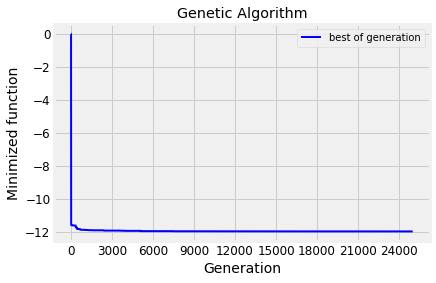

In [191]:
model1.run()

In [192]:
# RMSE 
optimized = val_rnn_15_predict_result * model1.output_dict['variable'][0] + val_lstm_15_predict_result *model1.output_dict['variable'][1] + val_slstm_15_predict_result * model1.output_dict['variable'][2] + val_bilstm_15_predict_result * model1.output_dict['variable'][3] + val_gru_15_predict_result * model1.output_dict['variable'][4]
optimized_rmse_15 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_15

18.028317944120083

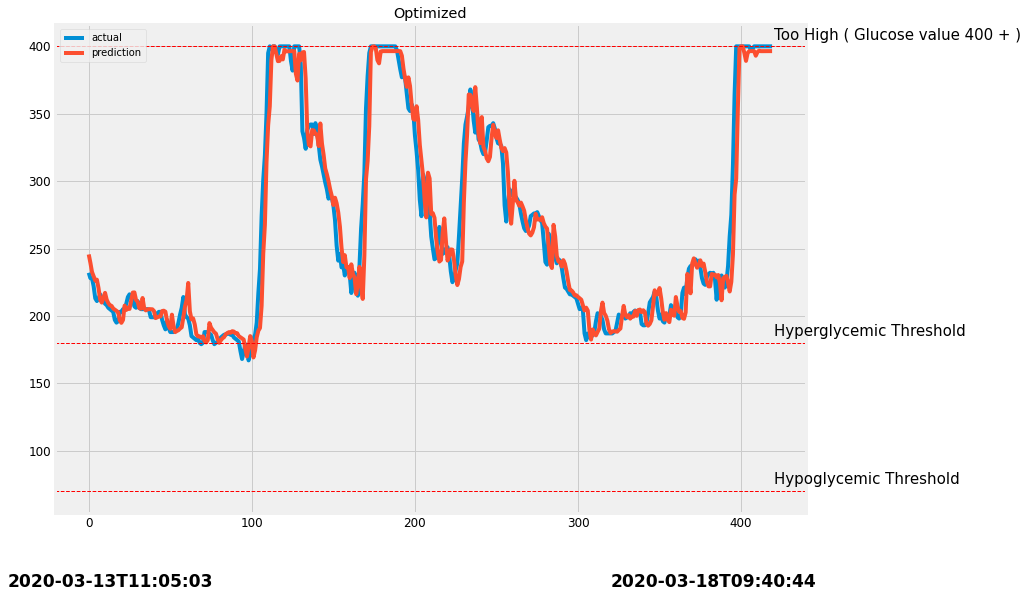

In [193]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 30분

In [194]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [195]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=5
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [196]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [197]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [198]:
y_val_uni.shape


(417,)

In [199]:

x_val_uni.shape

(417, 6, 1)

In [200]:
x_train_uni[0]

array([[216],
       [244],
       [227],
       [227],
       [224],
       [223]])

In [201]:
df['Glucose'].head(15)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    197
Name: Glucose, dtype: object

In [202]:
y_train_uni[0]

223

### RNN - 30분

In [203]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [204]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],return_sequences=False))
model.add(Dense(1))

In [205]:
model.compile(optimizer='adam',loss='mse')

In [206]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [207]:
val_rnn_30_predict_result = model.predict(x_val_uni,verbose=0)

In [208]:
K.clear_session()

In [209]:
predict_result = model.predict(x_val_uni,verbose=0)

In [210]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
# GA에 사용 
val_rnn_30_predict_result = predict_result

In [211]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  35.233955666392475


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

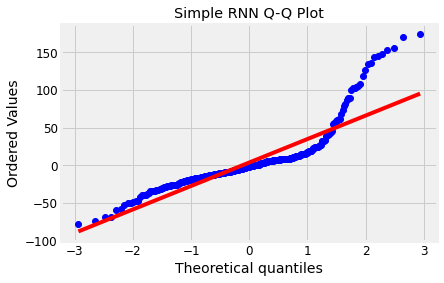

In [212]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

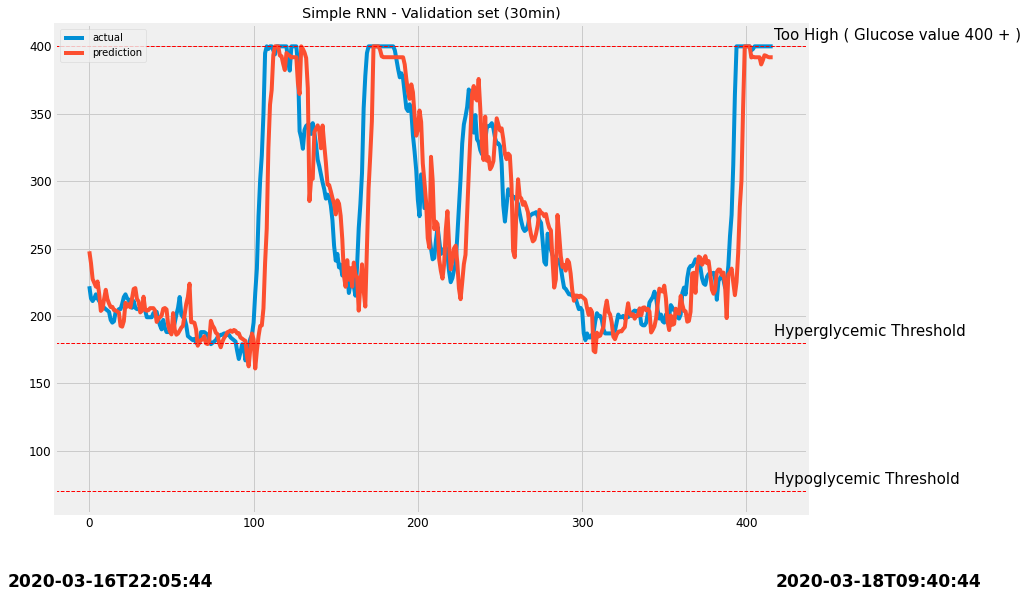

In [213]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

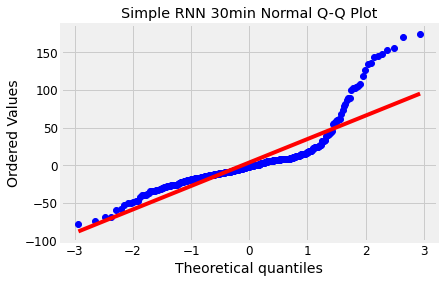

In [214]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [215]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  29.739643488713902


#### Train

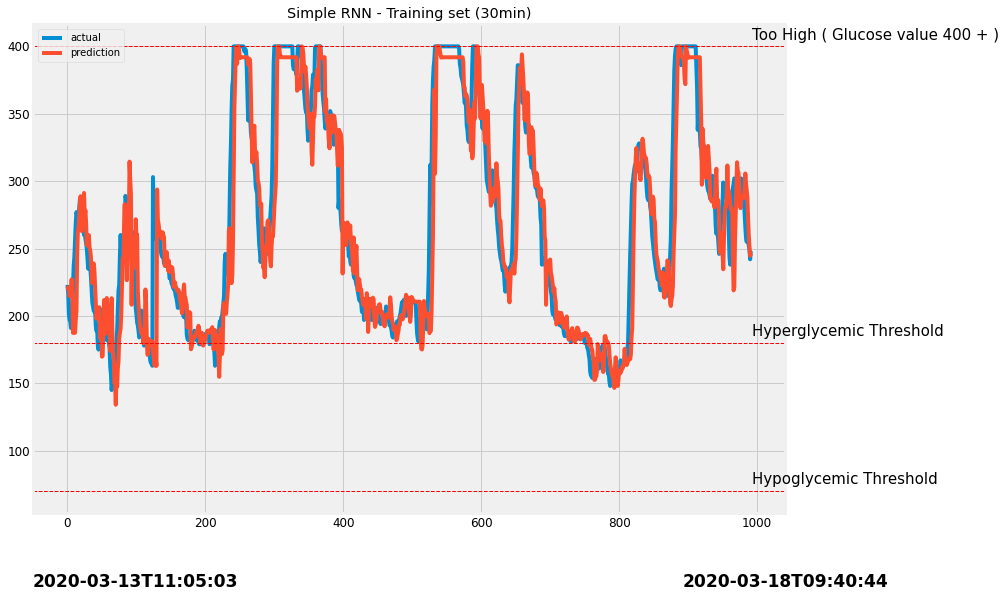

In [216]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [217]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [218]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))


In [219]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
val_lstm_30_predict_result = model.predict(x_val_uni,verbose=0)
K.clear_session()

In [220]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  35.29307450648988


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

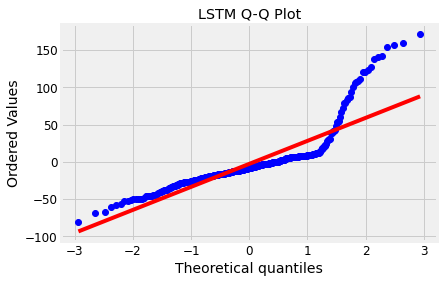

In [221]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

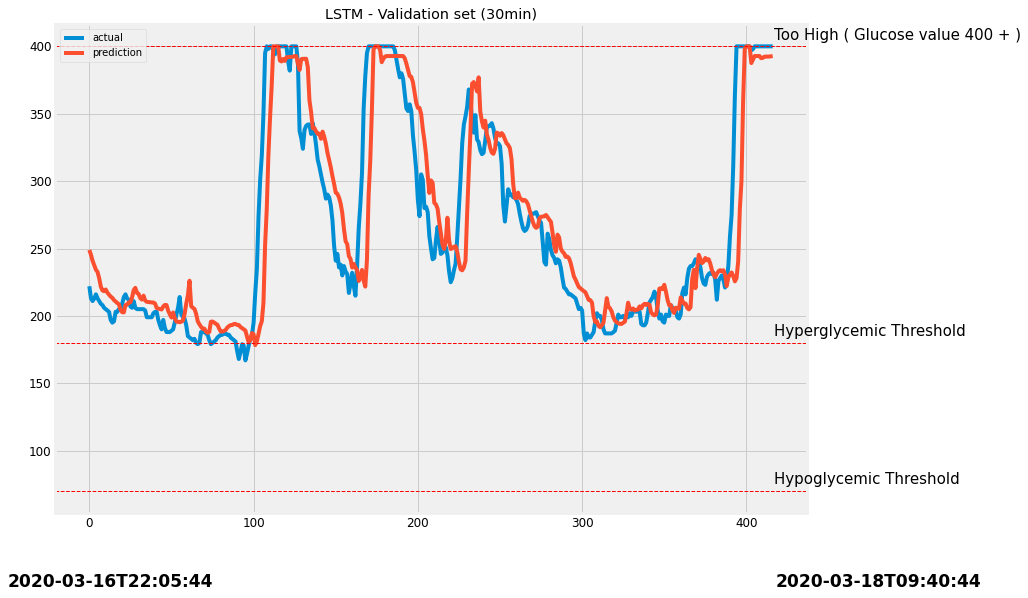

In [222]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [223]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  30.4412160973773


#### Train

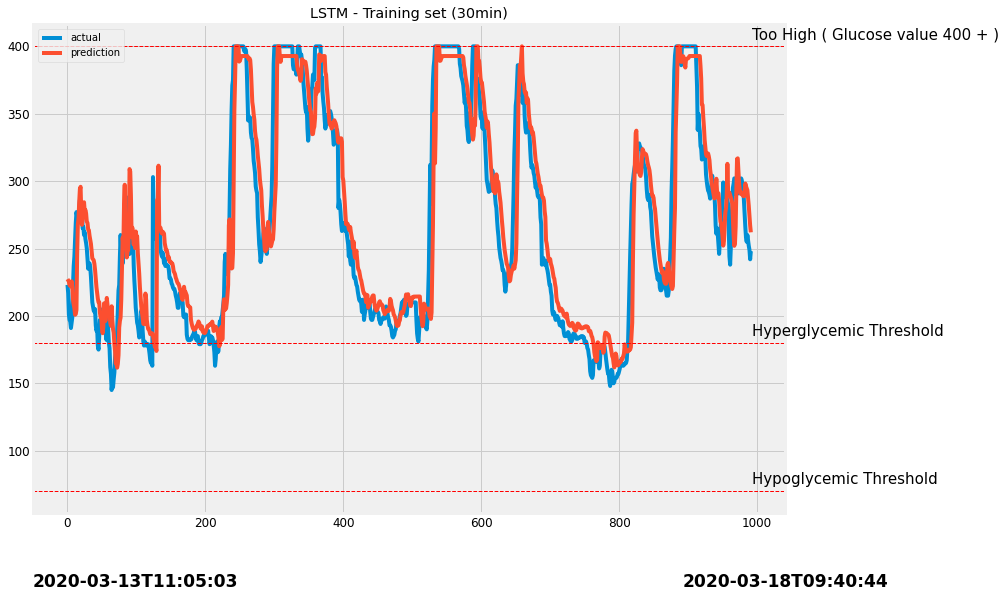

In [224]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [225]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [226]:
model = Sequential()
#model.Flatten()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:]))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [227]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [228]:
K.clear_session()

In [229]:
val_slstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [230]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  32.62608328908094


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

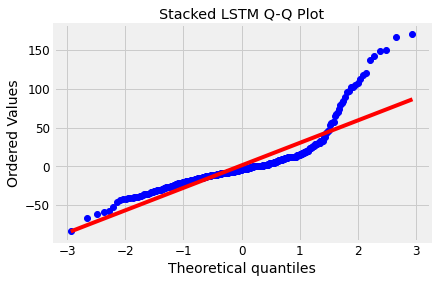

In [231]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

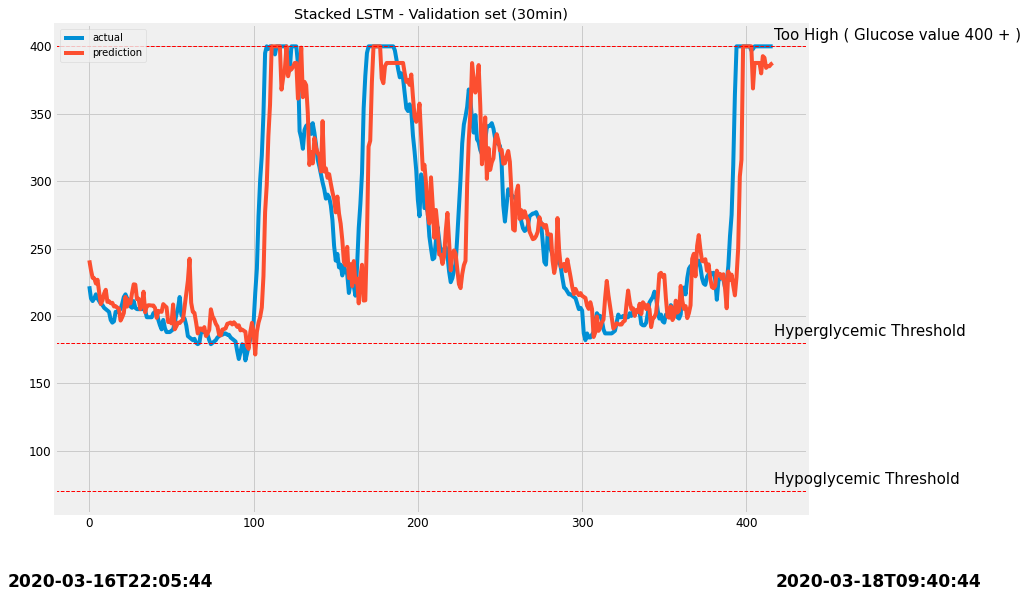

In [232]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [233]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  28.519147998582216


#### Train

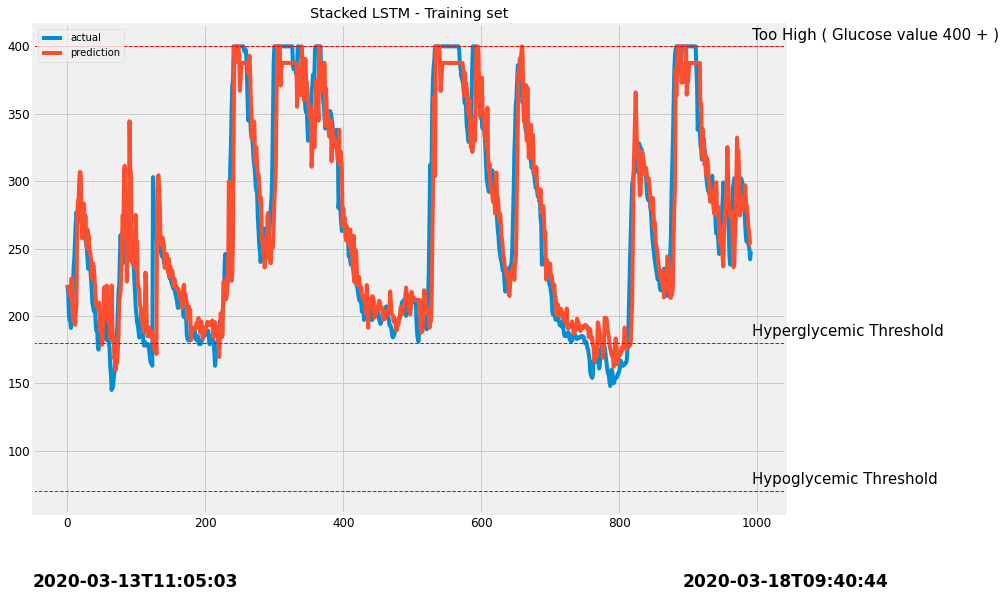

In [234]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [235]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [236]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [237]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

In [238]:
val_bilstm_30_predict_result = model.predict(x_val_uni,verbose=0)

In [239]:
K.clear_session()

In [240]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  36.06363792990437


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

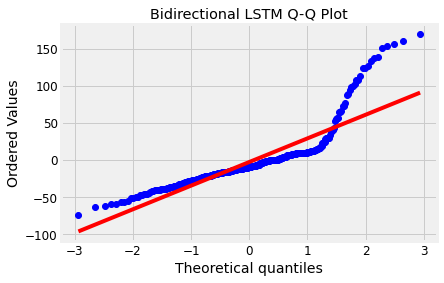

In [241]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

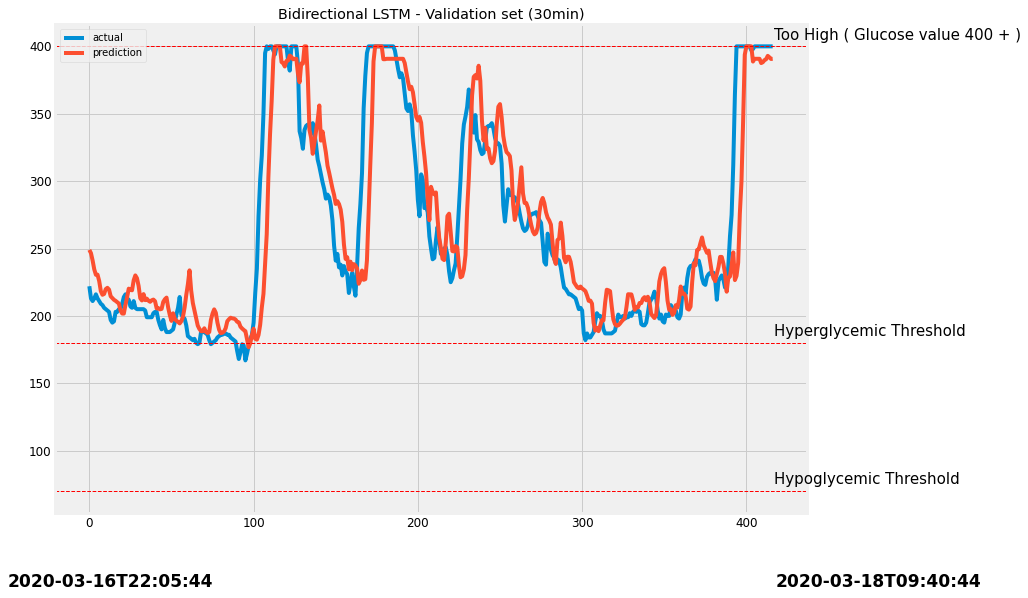

In [242]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [243]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  30.202906360826013


#### Train

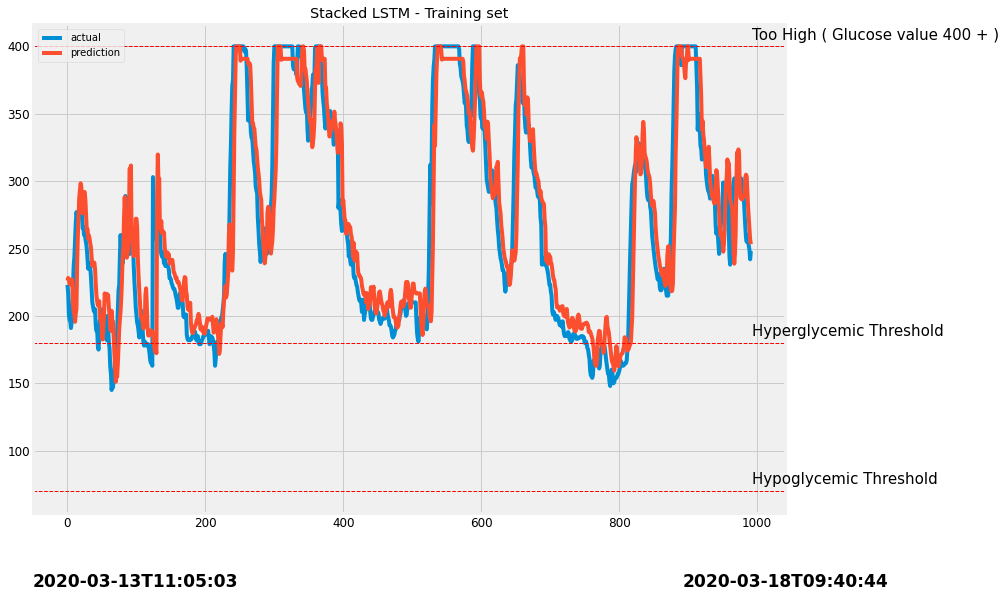

In [244]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [245]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [246]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2))
#model.add(GRU(50,activation=leaky_relu,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [247]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_gru_30_predict_result = model.predict(x_val_uni,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [248]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  36.473016338392085


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

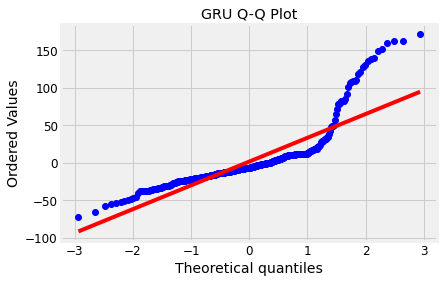

In [249]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

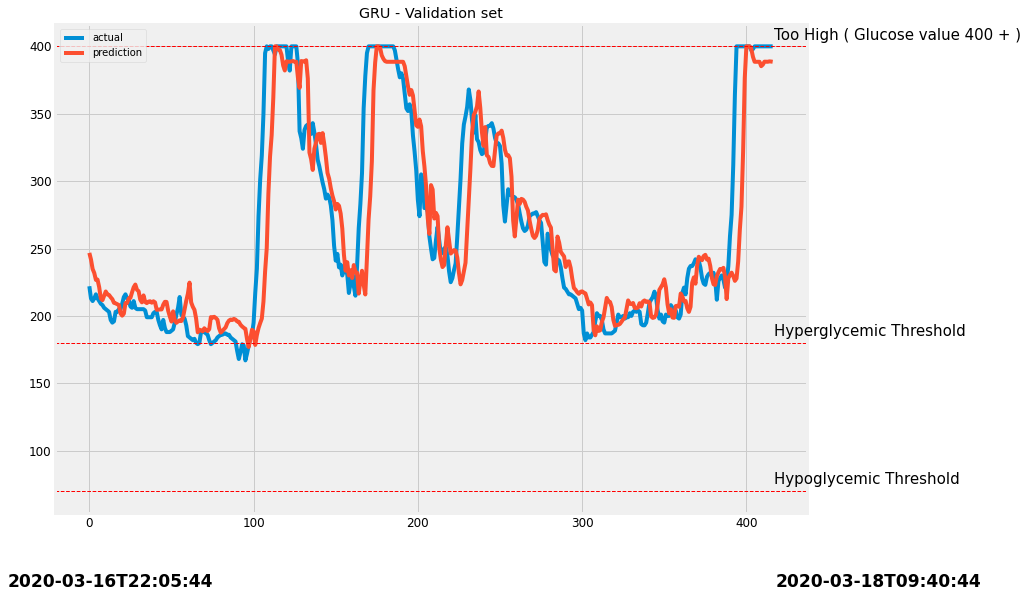

In [250]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [251]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  30.74874834913127


#### Train

### GA

In [252]:
#ex = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 + val_gru_30_predict_result * 0.2

In [253]:
#ex2 = val_rnn_30_predict_result * 0.43578443     + val_lstm_30_predict_result *  0.07653674+ val_slstm_30_predict_result *  0.07391771 + val_bilstm_30_predict_result * 0.05667096+ val_gru_30_predict_result *0.34709233

In [254]:
#test_result =  RMSE(y_val_uni_origin,ex2)
#test_result

In [255]:
#test_result =  mean_squared_error(y_val_uni_origin,ex)
#test_result

In [256]:
#test_result * 2 - (1000 + test_result)

In [257]:
#result = (test_result*2) - (1000 + mean_squared_error(y_val_uni_origin,abc))

In [258]:
#mean_squared_error

In [259]:
val_rnn_30_predict_result = np.asarray(val_rnn_30_predict_result)
val_lstm_30_predict_result = np.asarray(val_lstm_30_predict_result)
val_slstm_30_predict_result = np.asarray(val_slstm_30_predict_result)
val_bilstm_30_predict_result = np.asarray(val_bilstm_30_predict_result)
val_gru_30_predict_result = np.asarray(val_gru_30_predict_result)

In [260]:
#def evaluate2(X):
#  pen = 0 
  #coef = [0,0,0,0,0]
#  result =0
  #result2 = 0
  #print(X)
#  if sum(X) > 0.99 and sum(X) < 1:
#    print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
 #   abc = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
  #  result = (test_result*2) - ((test_result/2) + mean_squared_error(y_val_uni_origin,abc))
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
   # print("\n ** B ** \n")
    #print(X)
    #print()
    #print("\n ** C ** \n")
    #print(result)
  #return np.sum(X) + pen
    #count += 1 
  #return -result
    
    

In [261]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 50 - np.sqrt(mean_squared_error(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + 
                                val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [262]:
#abc.shape

In [263]:
#y_val_uni_origin.shape

In [264]:
#val_rnn_30_predict_result.shape

In [265]:
#abc = val_rnn_30_predict_result * 0.2 + val_lstm_30_predict_result * 0.2 + val_slstm_30_predict_result * 0.2 + val_bilstm_30_predict_result * 0.2 +val_gru_30_predict_result * 0.2
              

In [266]:
#get = mean_squared_error(y_val_uni_origin,abc)

In [267]:
#test_result*2 - mean_squared_error(y_val_uni_origin,abc)

In [268]:
#varbound = np.array([[500,5000]]*5)

In [269]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [270]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [271]:
#model = ga(function = evaluate, dimension = 5, variable_type='int',variable_boundaries=varbound,algorithm_parameters = algorithm_param)

In [272]:
model2 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.26719596 0.12501054 0.49975241 0.05000278 0.05000165]

 ** C ** 

16.12894072780947

 ** B ** 

[0.26719596 0.13056312 0.49990236 0.05000278 0.05000165]

 ** C ** 

16.167204379818287

 ** B ** 

[0.26719596 0.13056312 0.49995494 0.05000278 0.05000165]

 ** C ** 

16.167290914388246

 ** B ** 

[0.26719596 0.13056312 0.49999817 0.05000278 0.05000165]

 ** C ** 

16.167357546755007

 ** B ** 

[0.26719596 0.13056312 0.49975162 0.05000278 0.05000165]

 ** C ** 

16.16692506492921

 ** B ** 

[0.26719596 0.13056312 0.49975162 0.05000278 0.05000165]

 ** C ** 

16.16692506492921

 ** B ** 

[0.26719596 0.12501054 0.49999817 0.05000278 0.05000165]

 ** C ** 

16.13241539307885

 ** B ** 

[0.26719596 0.13056312 0.49975162 0.05000278 0.05000165]

 ** C ** 

16.16692506492921

 ** B ** 

[0.26719596 0.13056312 0.49999817 0.05000278 0.05000165]

 ** C ** 

16.167357546755007

 ** B ** 

[0.26719596 0.13056312 0.49999817 0.05000278 0.05000165]



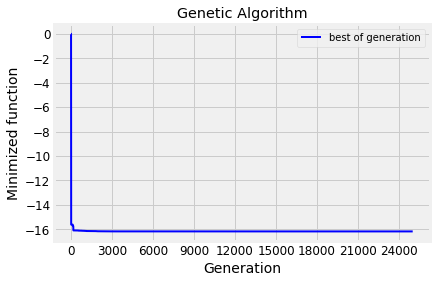

In [273]:
model2.run()

In [274]:
# RMSE 
optimized = val_rnn_30_predict_result * model2.output_dict['variable'][0] + val_lstm_30_predict_result *model2.output_dict['variable'][1] + val_slstm_30_predict_result * model2.output_dict['variable'][2] + val_bilstm_30_predict_result * model2.output_dict['variable'][3] + val_gru_30_predict_result * model2.output_dict['variable'][4]
optimized_rmse_30 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_30

33.83264245324499

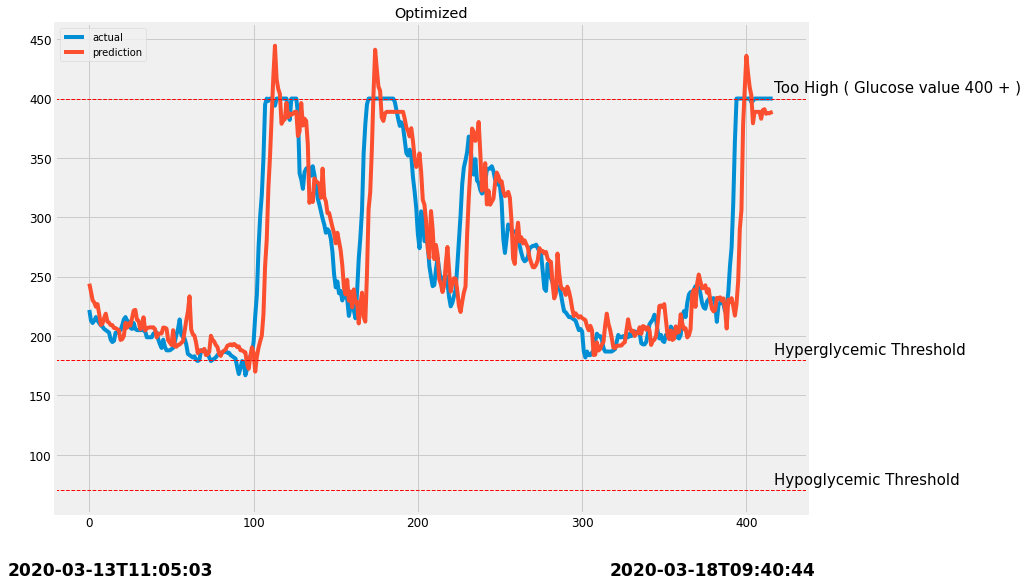

In [275]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [276]:
model2.output_dict

{'function': -16.167357546755007,
 'last_generation': {'scores': array([-16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.16735755, -16.16735755, -16.16735755,
         -16.16735755, -16.

In [277]:
#model2.output_dict['variable'][0]


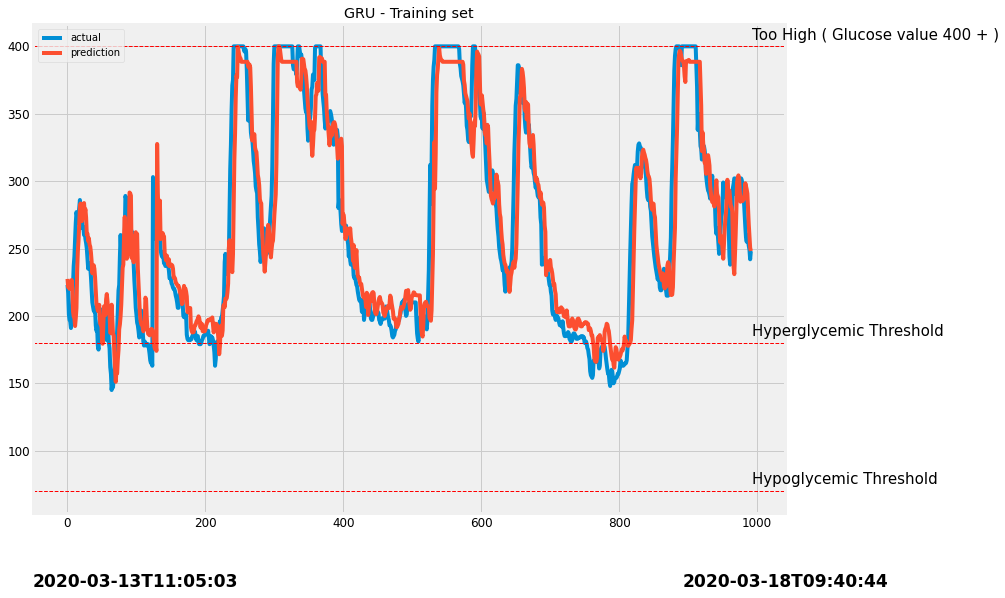

In [278]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

In [279]:
# SG필터 테스트 
#import scipy.signal 

#yhat = scipy.signal.savgol_filter(raw_seq,15,5)
#plt.plot(raw_seq)
#plt.plot(yhat,color='red')
#plt.show()

In [280]:
#TRAIN_SPLIT=int(len(raw_seq)*0.7)
#uni_past_history=6
#uni_future_target=11
#x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
#                                  uni_past_history,
#                                  uni_future_target)
#x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
#                            uni_past_history,
#                            uni_future_target)



In [281]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [282]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [283]:
x_train_uni[0]

array([[216],
       [244],
       [227],
       [227],
       [224],
       [223]])

In [284]:
y_train_uni[0]

195

In [285]:
df['Glucose'].head(20)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    197
15    196
16    191
17    195
18    199
19    223
Name: Glucose, dtype: object

### RNN - 60분

In [286]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [287]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=x_train_uni.shape[-2:],recurrent_dropout=0.2)) # recurrent_dropout=0.2
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)
K.clear_session()

In [288]:
val_rnn_60_predict_result = model.predict(x_val_uni,verbose=0)

In [289]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  59.244369324109826


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

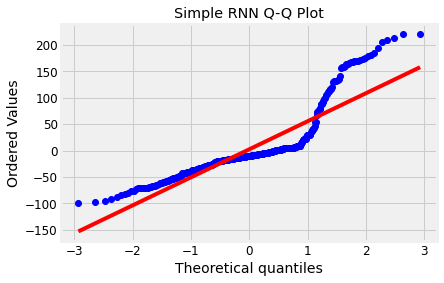

In [290]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

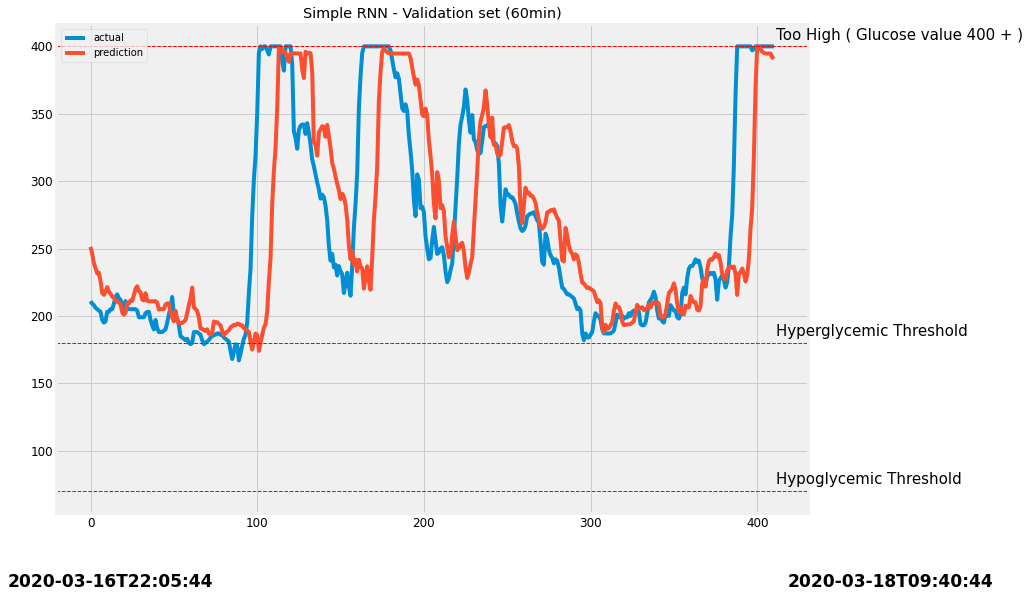

In [291]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

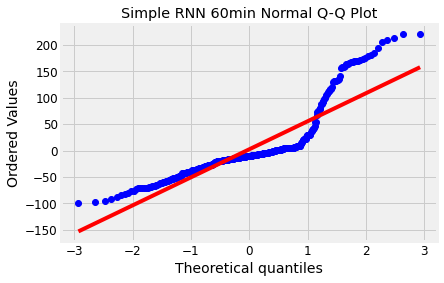

In [292]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [293]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  50.28527064432609


#### Train

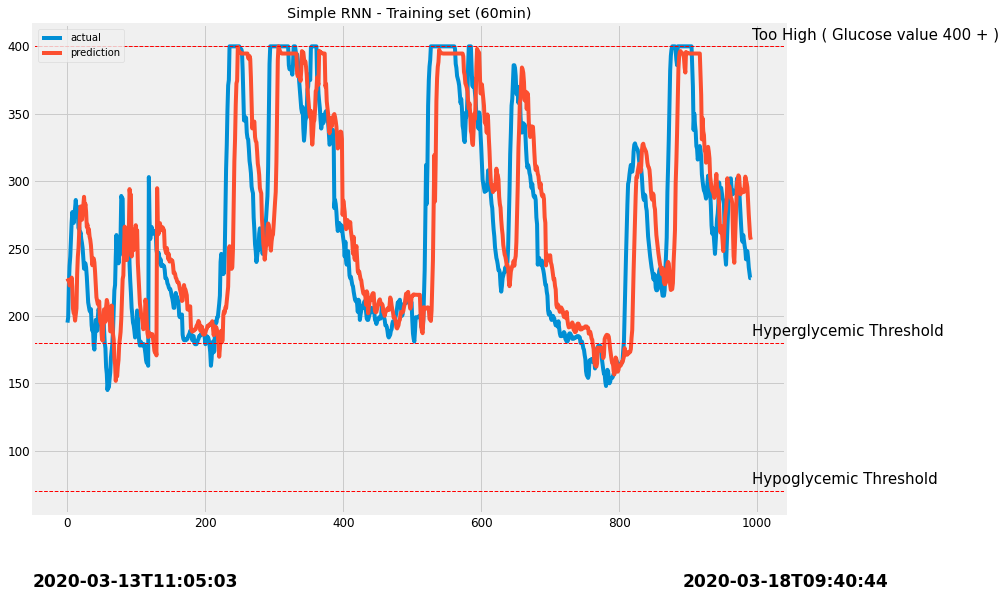

In [294]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [295]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [296]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=x_train_uni.shape[-2:]))  #recurrent_dropout=0.2, unit_forget_bias=False
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_lstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [297]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (60min) :  54.16604126101961


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

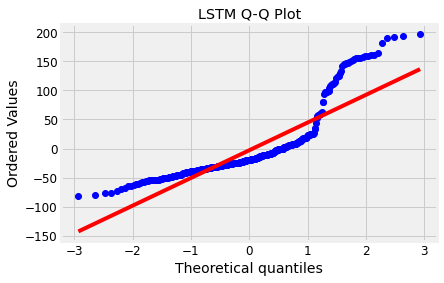

In [298]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

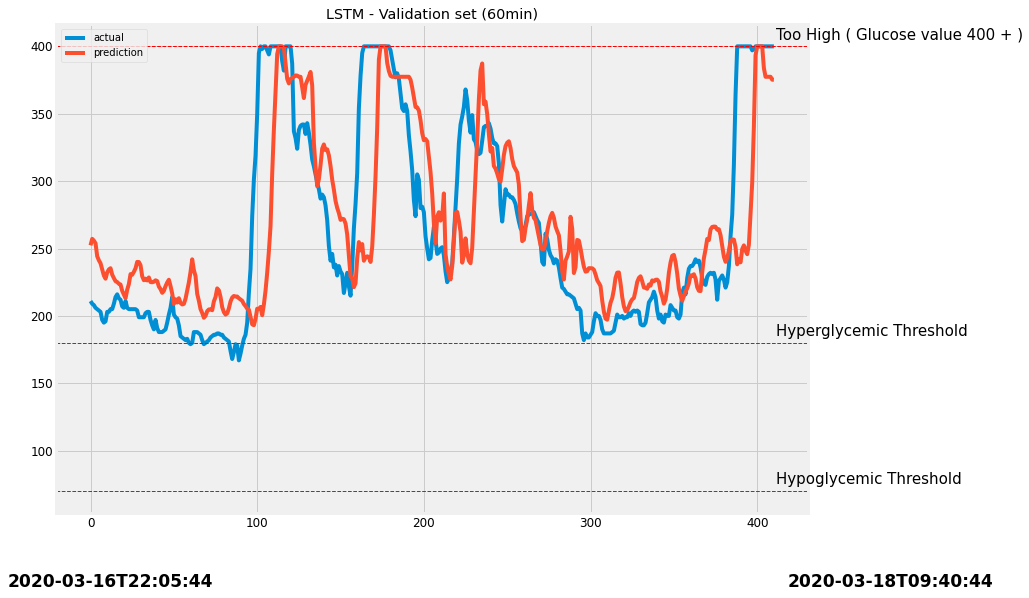

In [299]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [300]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (60min) Training set :  46.72332238601808


#### Train

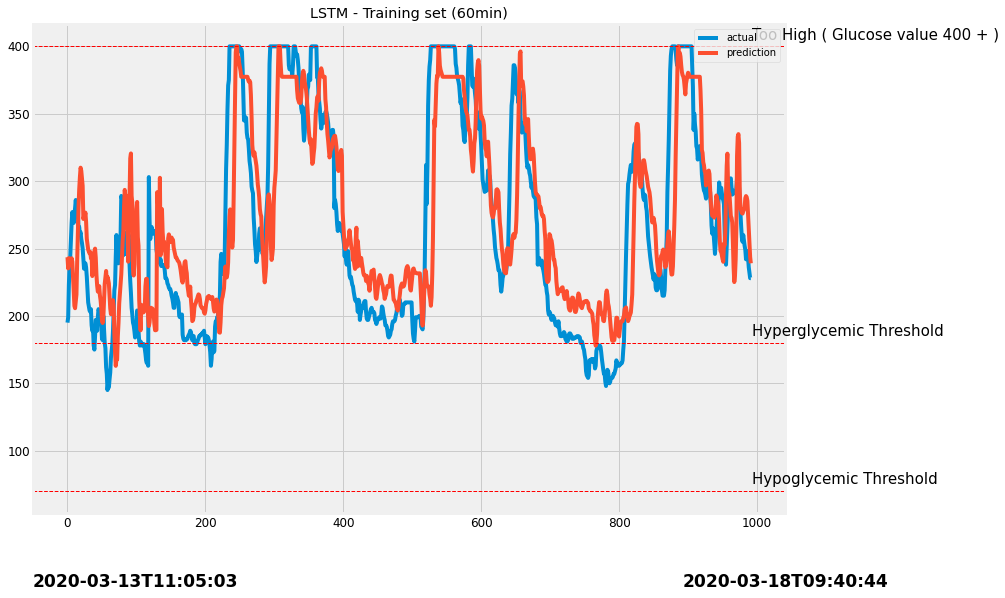

In [301]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [302]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [303]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=x_train_uni.shape[-2:])) # recurrent_dropout=0.2
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [304]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

In [305]:
val_slstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [306]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  51.57831576939


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

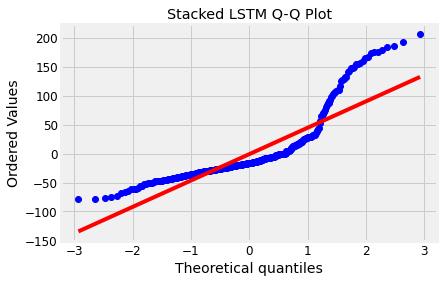

In [307]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

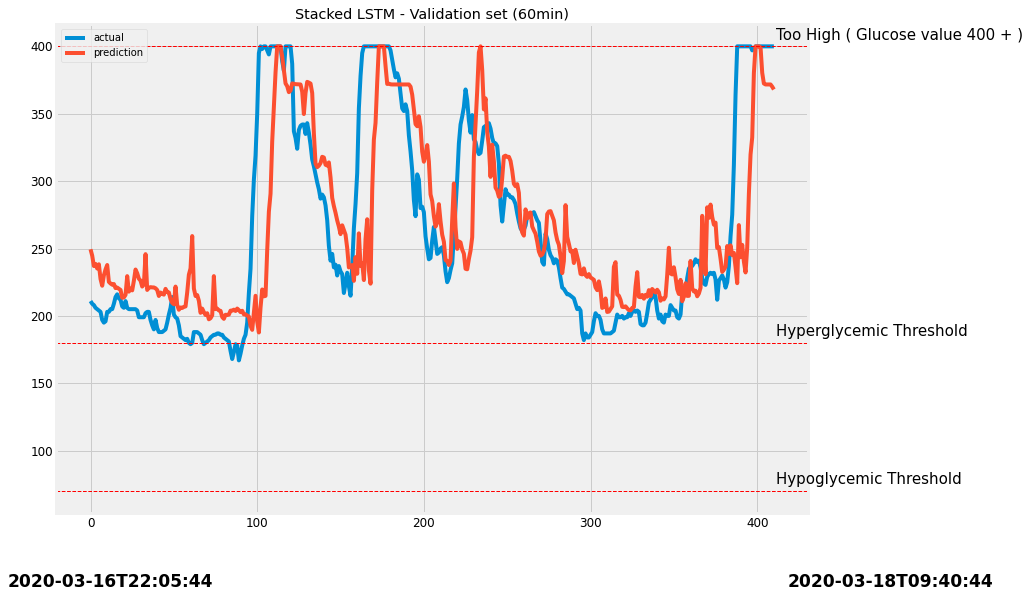

In [308]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [309]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  44.806261050661476


#### Train

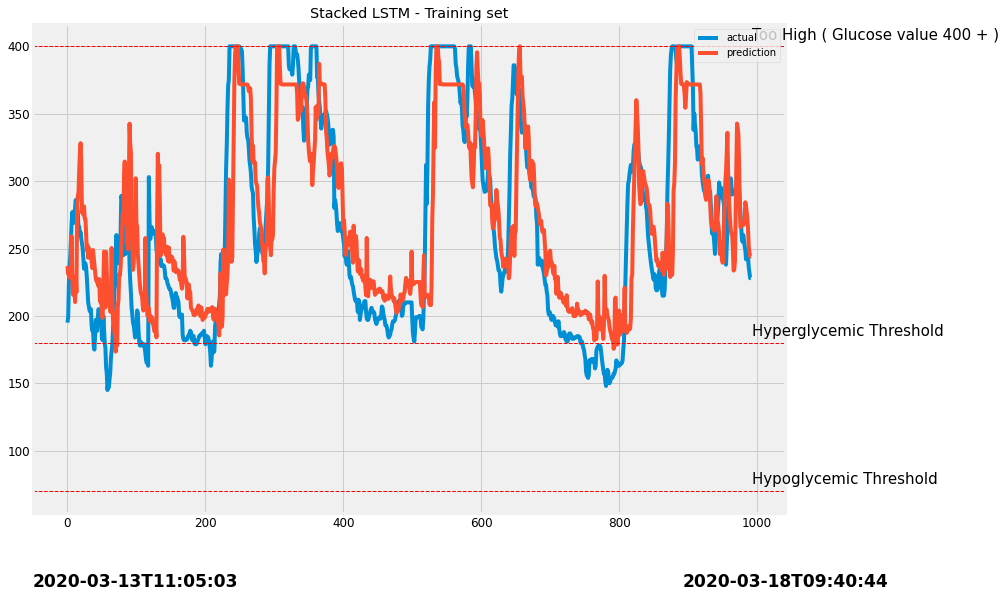

In [310]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [311]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [312]:
from keras.layers import Bidirectional
from tensorflow.keras import layers
model = Sequential()

model.add(Bidirectional(LSTM(50,activation='relu',return_sequences=True),input_shape=x_train_uni.shape[-2:]))
model.add(Bidirectional(layers.LSTM(50,activation='relu')))
#model.add(Bidirectional(forward_layer,backward_layer=backward_layer,input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [313]:
model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()
val_bilstm_60_predict_result = model.predict(x_val_uni,verbose=0)

In [314]:
predict_result.shape

(992, 1)

In [315]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  53.018120903551825


#### Validation

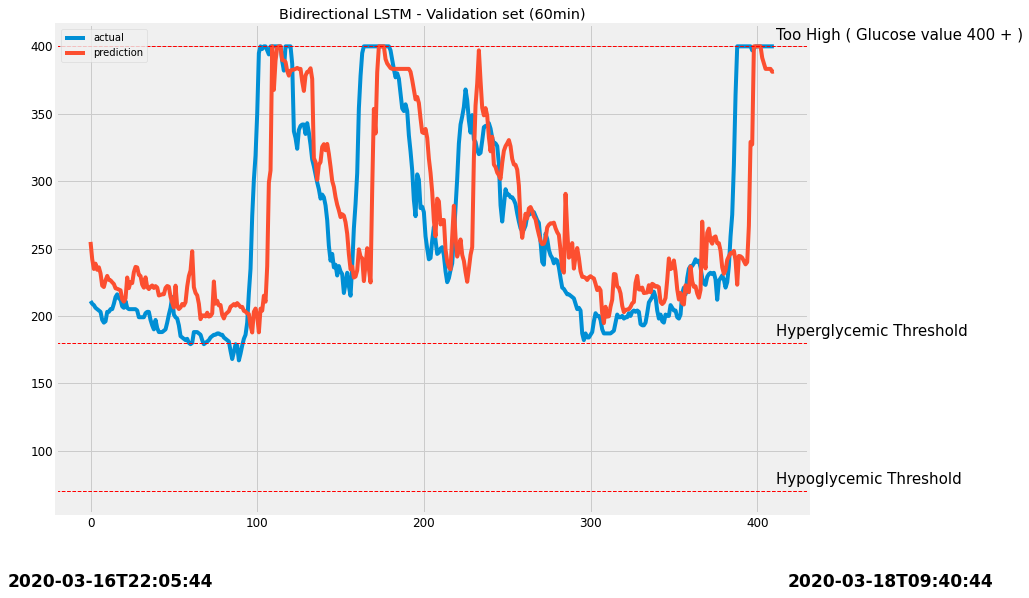

In [316]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

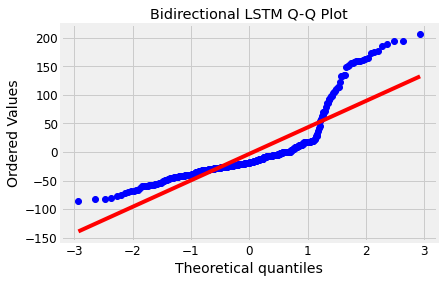

In [317]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [318]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  45.21578670970841


#### Train

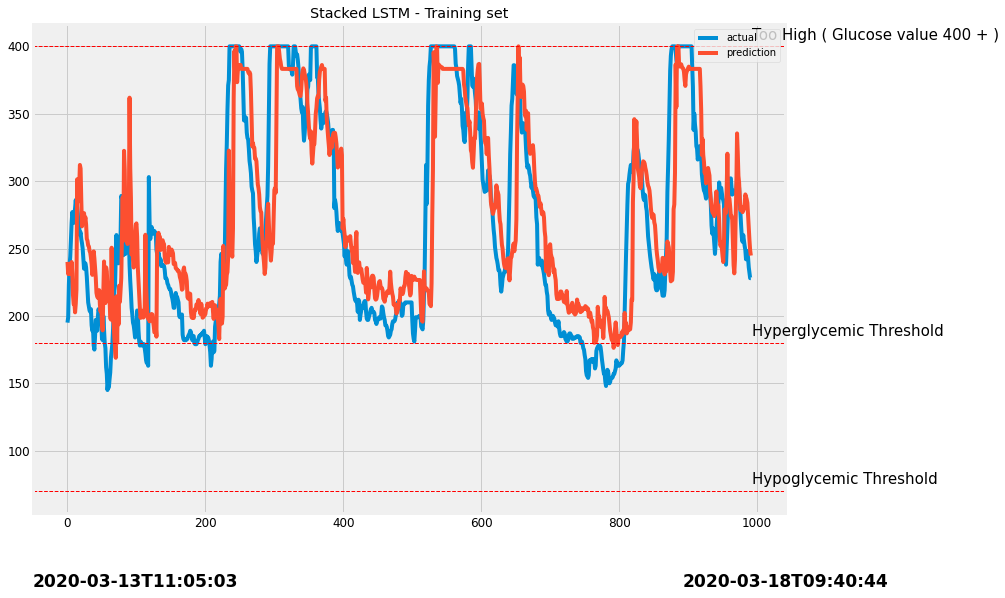

In [319]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [320]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [321]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=x_train_uni.shape[-2:]))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [322]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=300,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [323]:
val_gru_60_predict_result = model.predict(x_val_uni,verbose=0)
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 60min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 60min :  53.830454871034945


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

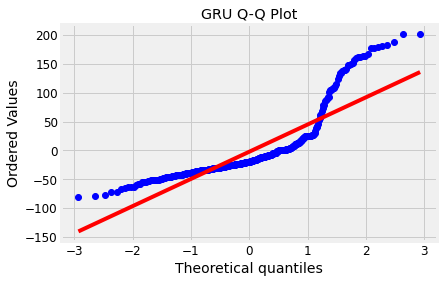

In [324]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

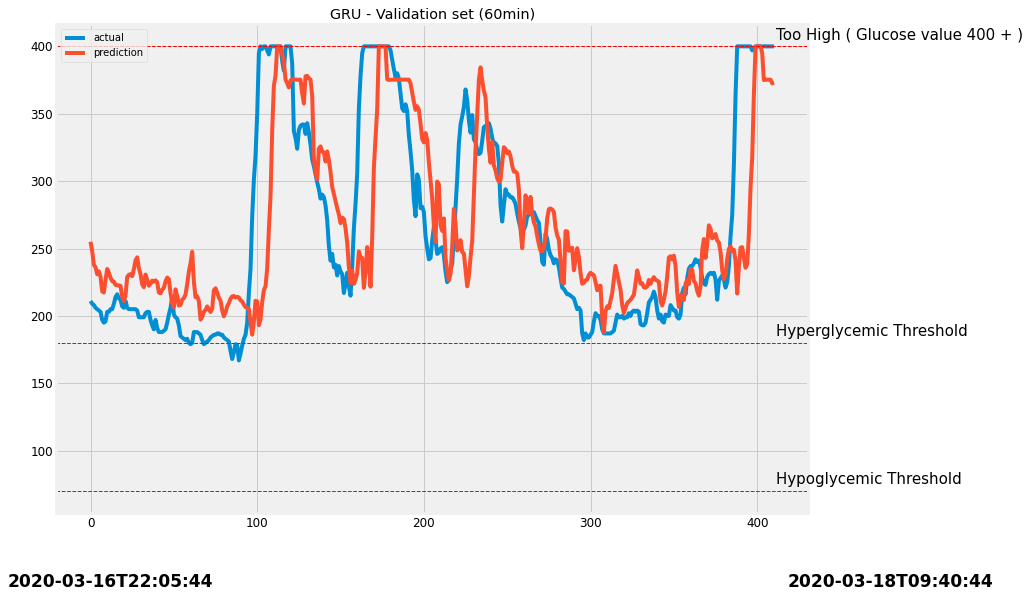

In [325]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [326]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (60min) Training set :  45.72223343576112


#### Train

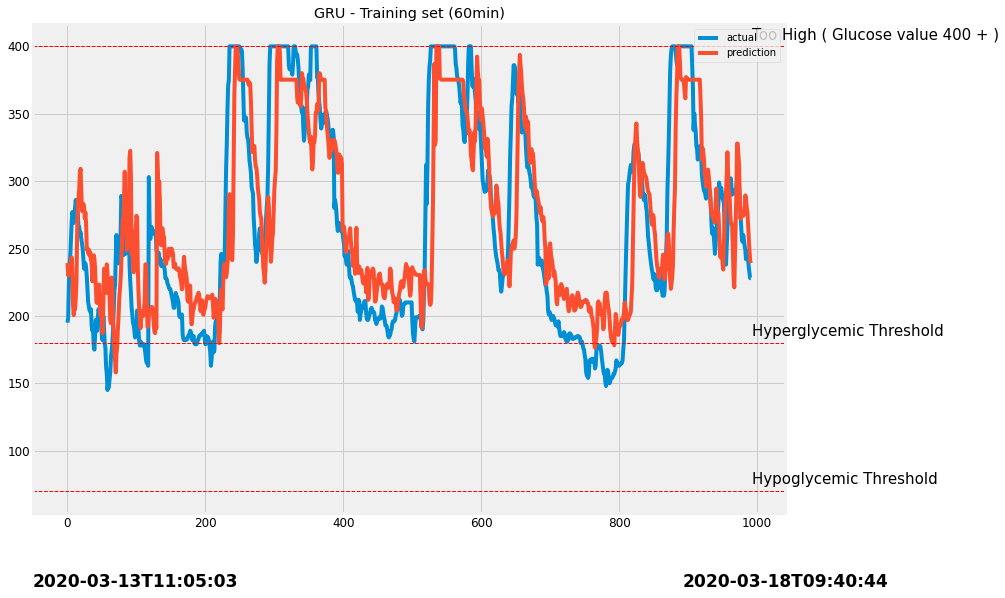

In [327]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GA

In [328]:
val_rnn_60_predict_result = np.asarray(val_rnn_60_predict_result)
val_lstm_60_predict_result = np.asarray(val_lstm_60_predict_result)
val_slstm_60_predict_result = np.asarray(val_slstm_60_predict_result)
val_bilstm_60_predict_result = np.asarray(val_bilstm_60_predict_result)
val_gru_60_predict_result = np.asarray(val_gru_60_predict_result)

In [329]:
def evaluate2(X):
  pen = 0 
  #coef = [0,0,0,0,0]
  ab=0
  result =0
  #result2 = 0
  #print(X)
  if sum(X) > 0.99 and sum(X) < 1:
    #print("\n ** Count ** ")
    #print(count)
    #sum(coef)
    #pen = 2000 - sum(list1 * coef[0] + list2 * coef[1] + # 400 = 혈당측정기에서 수집한 EGV의 최댓값이 400
    #             list3 * coef[2] + list4 * coef[3] +
    #             list5 * coef[4])
    #RMSE(y_val_uni_origin,predict_result)
    #result = mean_squared_error((y_val_uni_origin,(val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +
    #             val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] +
    #             val_gru_30_predict_result * X[4]))**0.5)
   # ab = val_rnn_30_predict_result * X[0] + val_lstm_30_predict_result * X[1] +val_slstm_30_predict_result * X[2] + val_bilstm_30_predict_result * X[3] + val_gru_30_predict_result * X[4]
   # print("\n ** A ** \n")
   # print(ab.shape)
    result = 100 - np.sqrt(mean_squared_error(val_rnn_60_predict_result * X[0] + val_lstm_60_predict_result * X[1] +val_slstm_60_predict_result * X[2] + 
                                val_bilstm_60_predict_result * X[3] + val_gru_60_predict_result * X[4],y_val_uni_origin))
    
    #result = 10 - mean_squared_error(y_val_uni_origin,abc) / test_result 
    #result2=(test_result*5) - np.sqrt(result)
    #test_result =  mean_squared_error(y_val_uni_origin,ex)
    #test_result

    #pen = RMSE(y_val_uni_origin,result)
    #pen = 200 - np.sqrt(y_val_uni_origin,(val_rnn_15_predict_result * (X[0] / 10000) + val_lstm_15_predict_result * (X[1] / 10000) +
    #             val_slstm_15_predict_result * (X[2] / 10000) + val_bilstm_15_predict_result * (X[3] / 10000) +
    #             val_gru_15_predict_result * (X[4] / 10000)))
    # np.sqrt(mean_squared_error(y_test,y_predict))
    print("\n ** B ** \n")
    print(X)
    #print()
    print("\n ** C ** \n")
    print(result)
  #return np.sum(X) + pen
    #count += 1 
  return -result
    
    

In [330]:
varbound2 = np.array([[0.05, 0.5]]*5)

In [331]:
algorithm_param = {'max_num_iteration': 25000,
                   'population_size':100,
                   'mutation_probability':0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type':'uniform',
                   'selection_type': 'roulette',
                   'max_iteration_without_improv':None}

In [332]:
model3 = ga(function = evaluate2, dimension = 5, variable_type='real',variable_boundaries=varbound2,algorithm_parameters = algorithm_param)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05000312]

 ** C ** 

47.56806469075443

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05000312]

 ** C ** 

47.56806469075443

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.0500921 ]

 ** C ** 

47.56728875962729

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05000312]

 ** C ** 

47.56806469075443

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.0500921 ]

 ** C ** 

47.56728875962729

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05490445]

 ** C ** 

47.508395038489425

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05000312]

 ** C ** 

47.56806469075443

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.0500921 ]

 ** C ** 

47.56728875962729

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.0500921 ]

 ** C ** 

47.56728875962729

 ** B ** 

[0.05043926 0.05566599 0.49926452 0.33462739 0.05373158]

 **

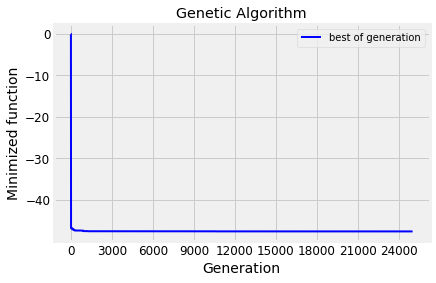

In [333]:
model3.run()

In [334]:
# RMSE 
optimized = val_rnn_60_predict_result * model3.output_dict['variable'][0] + val_lstm_60_predict_result *model3.output_dict['variable'][1] + val_slstm_60_predict_result * model3.output_dict['variable'][2] + val_bilstm_60_predict_result * model3.output_dict['variable'][3] + val_gru_60_predict_result * model3.output_dict['variable'][4]
optimized_rmse_60 =  RMSE(y_val_uni_origin,optimized)
optimized_rmse_60

52.43193530924557

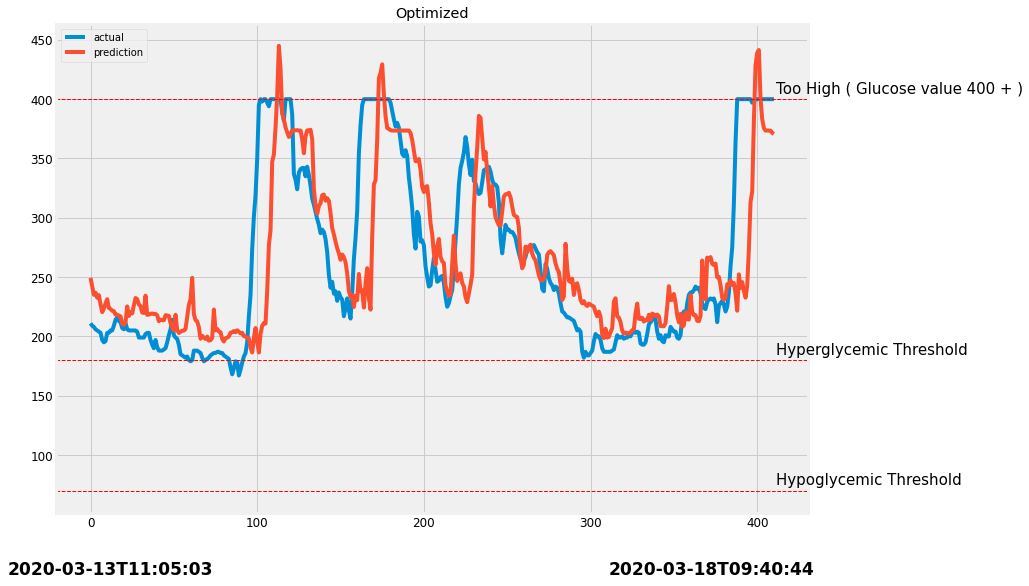

In [335]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(optimized,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(y_val_uni_origin),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(y_val_uni_origin),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Optimized',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(y_val_uni_origin)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [336]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15,optimized_rmse_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30,optimized_rmse_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60,optimized_rmse_60]


In [337]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]
val_optimized_result = [optimized_rmse_15,optimized_rmse_30,optimized_rmse_60]

In [338]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [339]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result,]

In [340]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result,val_optimized_result]

In [341]:
val_result_list

[[19.58, 35.233955666392475, 59.244369324109826],
 [20.46, 35.29307450648988, 54.16604126101961],
 [17.53, 32.62608328908094, 51.57831576939],
 [18.66, 36.06363792990437, 53.018120903551825],
 [18.99, 36.473016338392085, 53.830454871034945],
 [18.028317944120083, 33.83264245324499, 52.43193530924557]]

In [342]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU','Optimized'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 19.580000  35.233956  59.244369
LSTM                20.460000  35.293075  54.166041
Stacked LSTM        17.530000  32.626083  51.578316
Bidirectional LSTM  18.660000  36.063638  53.018121
GRU                 18.990000  36.473016  53.830455
Optimized           18.028318  33.832642  52.431935

In [343]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                 17.406504  29.739643  50.285271
LSTM                18.546729  30.441216  46.723322
Stacked LSTM        16.849284  28.519148  44.806261
Bidirectional LSTM  17.615753  30.202906  45.215787
GRU                 17.138180  30.748748  45.722233

## CNN LSTM